# CSE 258 Assignment 2 – Hawaii Rating Prediction (2017–2020 → 2021)

This notebook implements:
1. Read Hawaii 10-core review data + metadata
2. Prerocess and explore the data
   1. including cleaning, merging review–business tables, and performing basic descriptive analysis
3. Construct business-level features (location / price / total review count / historical rating / regional average review count)
4. Use 2017–2020 data to train models and predict 2021 business average ratings
   1. Models used: a time-decay weighted average baseline and an XGBoost regressor
   2. apply popularity-based sample weighting so businesses with more reviews receive higher influence
5. Evaluate and visualize prediction results
   1. computing metrics such as MSE, MAE, and R²
   2. plotting graphs for better visualization

In [2]:
import gzip
import json
from collections import defaultdict

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.cluster import KMeans

from xgboost import XGBRegressor

plt.rcParams["figure.figsize"] = (8, 6)

/opt/anaconda3/envs/jupyter_env/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## 0. Exploratory Data Analysis

### 0.0.0 File Path Configuration

In [3]:
REVIEW_PATH = "review-Hawaii_10.json.gz"
META_PATH = "meta-Hawaii.json.gz"

### 0.1 Load and Preprocess Data

In [4]:
# ---------- 1. Load full reviews ----------
reviews = pd.read_json(REVIEW_PATH, lines=True)
print("Total reviews:", len(reviews))
unique_review_gmap_ids = reviews["gmap_id"].unique()
print("Number of businesses appearing in reviews:", len(unique_review_gmap_ids))

# ---------- 2. Load meta data ----------
meta = pd.read_json(META_PATH, lines=True)

# ---------- 3. Filter meta to businesses that appear in reviews ----------
# Use name + address to deduplicate instead of gmap_id
meta_unique = meta.drop_duplicates(subset=["name", "address"])

# Keep only businesses that appear in reviews
business = meta_unique[meta_unique["gmap_id"].isin(unique_review_gmap_ids)].copy()
print("Number of businesses after filtering by reviews:", len(business))

# ---------- 4. Filter by latitude and longitude ----------
# Longitude: 154°41′W ≈ -154.6833, 162°W ≈ -162(West is negative)
# Latitude: 18°54′N ≈ 18.9, 28°15′N ≈ 28.25
lon_min = -162
lon_max = -154.6833
lat_min = 18.9
lat_max = 28.25

business = business[
    (business["longitude"].notnull()) &
    (business["latitude"].notnull()) &
    (business["longitude"] >= lon_min) &
    (business["longitude"] <= lon_max) &
    (business["latitude"] >= lat_min) &
    (business["latitude"] <= lat_max)
].copy()

print("Number of businesses after filtering by lat/lon:", len(business))

# ---------- 5. Reset index ----------
business.reset_index(drop=True, inplace=True)

business.head()

Total reviews: 1504347
Number of businesses appearing in reviews: 11686
Number of businesses after filtering by reviews: 11665
Number of businesses after filtering by lat/lon: 11661


,name,address,gmap_id,description,latitude,longitude,category,avg_rating,num_of_reviews,price,hours,MISC,state,relative_results,url
0,SMP - Single Marine Program,"SMP - Single Marine Program, G St, Kailua, HI ...",0x7c00159b5b1b1d25:0x8d2d85d4a758290e,None,21.440345,-157.754347,[Recreation center],4.1,18,None,"[[Thursday, 8AM–9PM], [Friday, 8AM–9PM], [Satu...",{'Accessibility': ['Wheelchair accessible entr...,Opens soon ⋅ 8AM,"[0x7c00155df23846af:0xfbe051d208292028, 0x7c00...",https://www.google.com/maps/place//data=!4m2!3...
1,Oahu Osteopathic Clinic,"Oahu Osteopathic Clinic, 1150 S King St #906, ...",0x7c006de89f2d86e1:0x23d998532e9317a6,None,21.300483,-157.844839,"[Medical clinic, Doctor, Osteopath]",4.6,8,None,"[[Thursday, 9:30AM–6PM], [Friday, 9:30AM–6PM],...",{'Accessibility': ['Wheelchair accessible entr...,Closed ⋅ Opens 9:30AM,"[0x7c00153987eef02f:0x8c6ab7ca33ed4d5e, 0x7c00...",https://www.google.com/maps/place//data=!4m2!3...
2,SlumberWorld Pearlridge,"SlumberWorld Pearlridge, 98-107 Kamehameha Hwy...",0x7c0065ffde090f89:0x910053daf03f6f3f,This mattress showroom with a tranquil vibe al...,21.383172,-157.946424,"[Furniture store, Bedding store]",4.7,78,None,"[[Thursday, 10AM–6PM], [Friday, 10AM–6PM], [Sa...","{'Service options': ['Curbside pickup', 'Deliv...",Closed ⋅ Opens 10AM,"[0x7c006f1351169e51:0xc750e2703f695365, 0x7c00...",https://www.google.com/maps/place//data=!4m2!3...
3,Imagery Hairstyling,"Imagery Hairstyling, 99-185 Moanalua Rd, Aiea,...",0x7c006f4a2bf83f7d:0x192f04f2b228fefe,None,21.379107,-157.931126,[Hair salon],4.6,18,None,None,"{'Health & safety': ['Appointment required'], ...",None,"[0x7c006f4a2af2ef65:0xc30cd6eb75154598, 0x7c00...",https://www.google.com/maps/place//data=!4m2!3...
4,Faith Collision Center Of Hawaii,"Faith Collision Center Of Hawaii, 39 Hoolai St...",0x7c0014db735170df:0xc68ef3d4982313c7,None,21.394730,-157.745290,[Auto body shop],4.7,28,None,"[[Wednesday, 7:30AM–4:30PM], [Thursday, 7:30AM...",{'From the business': ['Identifies as women-le...,Closed ⋅ Opens 7:30AM Thu,"[0x7c0014c347f82571:0x10c814af03fffa3e, 0x7c00...",https://www.google.com/maps/place//data=!4m2!3...


## 0.2 User and Business Analysis

### 0.2.1 Numbers of business and users; Business rating and review counts distributions

Number of businesses: 11661
Number of users: 64336


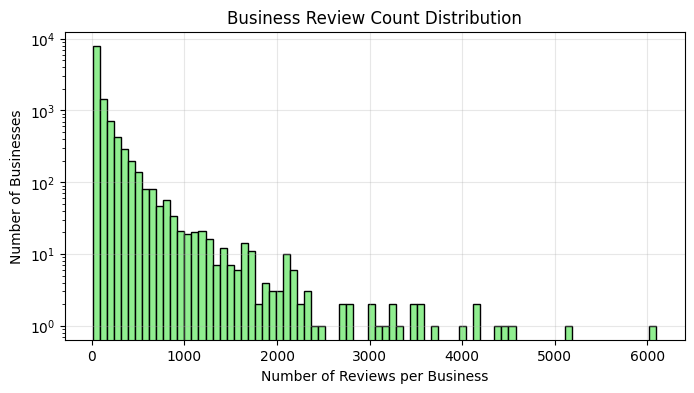

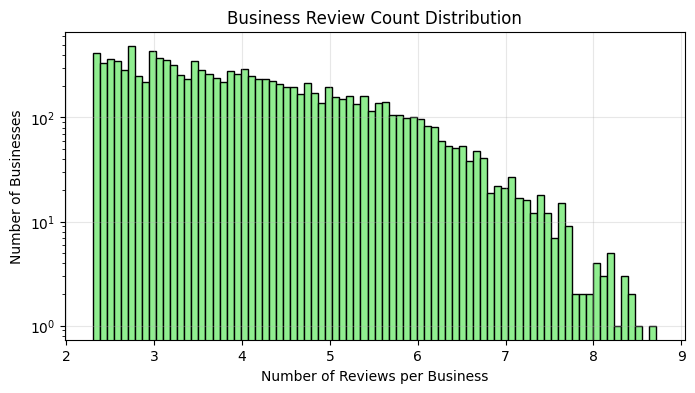

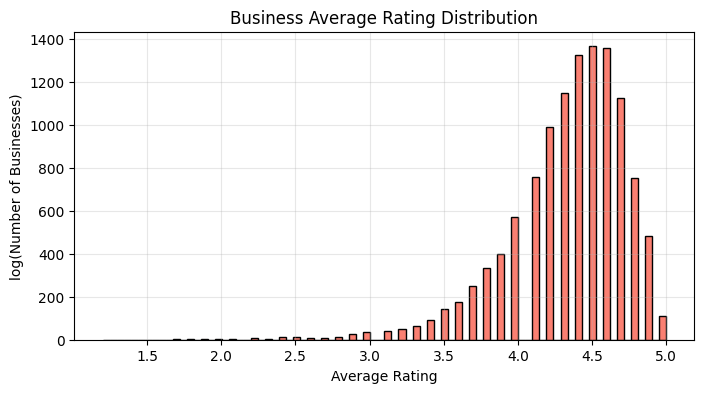

Business review count stats:
 count    11686.000000
mean       128.730703
std        278.293972
min         10.000000
25%         19.000000
50%         43.000000
75%        119.000000
max       6099.000000
dtype: float64
Business average rating stats:
 count    11661.000000
mean         4.332733
std          0.408668
min          1.200000
25%          4.100000
50%          4.400000
75%          4.600000
max          5.000000
Name: avg_rating, dtype: float64


In [8]:
import matplotlib.pyplot as plt

# ---------- 1. Number of businesses ----------
num_businesses = business.shape[0]
print("Number of businesses:", num_businesses)

# ---------- 2. Number of users ----------
num_users = reviews["user_id"].nunique()
print("Number of users:", num_users)

# ---------- 3. Business received review counts ----------
business_counts = reviews.groupby("gmap_id").size()
plt.figure(figsize=(8,4))
plt.hist(business_counts, bins=80, color='lightgreen', edgecolor='black')
plt.xlabel("Number of Reviews per Business")
plt.ylabel("Number of Businesses")
plt.title("Business Review Count Distribution")
plt.yscale('log')  # optional
plt.grid(True, alpha=0.3)
plt.show()

# x log
business_counts = reviews.groupby("gmap_id").size()
plt.figure(figsize=(8,4))
plt.hist(np.log(business_counts), bins=80, color='lightgreen', edgecolor='black')
plt.xlabel("Number of Reviews per Business")
plt.ylabel("Number of Businesses")
plt.title("Business Review Count Distribution")
plt.yscale('log')  # optional
plt.grid(True, alpha=0.3)
plt.show()

# ---------- 4. Business average rating distribution ----------
# Merge reviews with business avg_rating
business_avg_rating = business["avg_rating"].dropna()
plt.figure(figsize=(8,4))
plt.hist(business_avg_rating, bins=80, color='salmon', edgecolor='black')
plt.xlabel("Average Rating")
plt.ylabel("log(Number of Businesses)")
plt.title("Business Average Rating Distribution")
plt.grid(True, alpha=0.3)
plt.show()

# ---------- Summary ----------
print("Business review count stats:\n", business_counts.describe())
print("Business average rating stats:\n", business_avg_rating.describe())

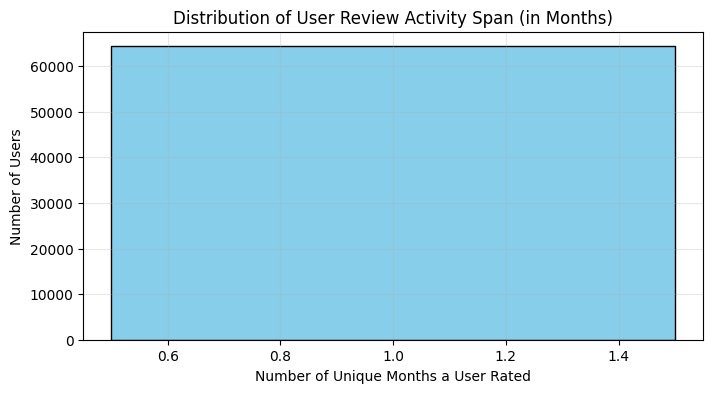

User month-count stats:
count    64336.0
mean         1.0
std          0.0
min          1.0
25%          1.0
50%          1.0
75%          1.0
max          1.0
Name: year_month, dtype: float64


user_id
1.000001e+20    1
1.000003e+20    1
1.000005e+20    1
1.000010e+20    1
1.000012e+20    1
Name: year_month, dtype: int64

In [35]:
# ---------- 5. Distribution of months in which each user writes reviews ----------
# Ensure datetime format
reviews["time_dt"] = pd.to_datetime(reviews["time"])

# Extract year-month string
reviews["year_month"] = reviews["time_dt"].dt.to_period("M")

# Count unique months per user
user_month_counts = (
    reviews.groupby("user_id")["year_month"]
    .nunique()
)

plt.figure(figsize=(8,4))
plt.hist(user_month_counts, bins=range(1, user_month_counts.max()+2), 
         color='skyblue', edgecolor='black', align='left')

plt.xlabel("Number of Unique Months a User Rated")
plt.ylabel("Number of Users")
plt.title("Distribution of User Review Activity Span (in Months)")
plt.grid(True, alpha=0.3)
plt.show()

print("User month-count stats:")
print(user_month_counts.describe())

user_month_counts.head()

Distinct months per user -- describe():
count    64336.000000
mean         5.141134
std          5.353868
min          1.000000
25%          2.000000
50%          3.000000
75%          7.000000
max         58.000000
Name: distinct_months, dtype: float64


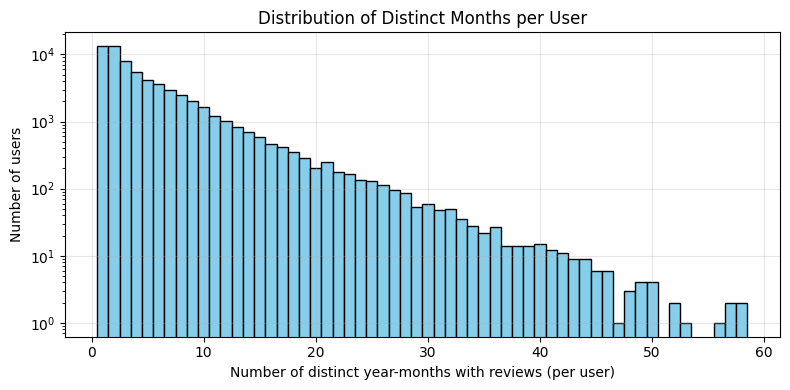

In [41]:
reviews["time_dt"] = pd.to_datetime(reviews["time"], unit="ms", errors="coerce")
reviews = reviews.dropna(subset=["time_dt"])

# --- 1) compute distinct year-month count per user (correct way) ---
reviews["year_month"] = reviews["time_dt"].dt.to_period("M")   # Year-month period, e.g. 2019-07

user_month_counts = reviews.groupby("user_id")["year_month"].nunique().rename("distinct_months")

# --- basic stats ---
print("Distinct months per user -- describe():")
print(user_month_counts.describe())

# --- 2) plot histogram of distinct months per user ---
plt.figure(figsize=(8,4))
plt.hist(user_month_counts, bins=range(1, user_month_counts.max()+2), align='left', color='skyblue', edgecolor='black')
plt.yscale('log')
plt.xlabel("Number of distinct year-months with reviews (per user)")
plt.ylabel("Number of users")
plt.title("Distribution of Distinct Months per User")
# plt.xticks(range(1, min(20, int(user_month_counts.max())+1)))  # show ticks up to 20 or max
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


### 2.2 Location of businesses

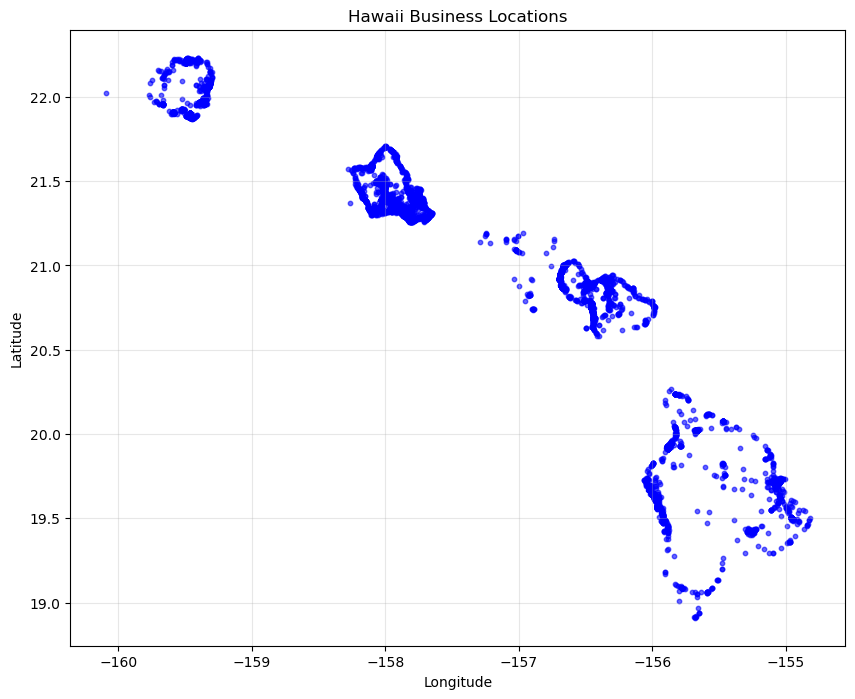

In [41]:
import folium
from folium.plugins import HeatMap
# Filter businesses with valid coordinates
business_coords = business.dropna(subset=["latitude", "longitude"])

# ---------- Scatter map ----------
plt.figure(figsize=(10,8))
plt.scatter(
    business_coords["longitude"], 
    business_coords["latitude"], 
    s=10,                 # point size
    c='blue',             # color
    alpha=0.6             # transparency
)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Hawaii Business Locations")
plt.grid(True, alpha=0.3)
plt.show()

# ---------- Initialize map centered on Hawaii ----------
hawaii_center = [20.5, -157.5]
m = folium.Map(location=hawaii_center, zoom_start=7, tiles="CartoDB positron")

# ---------- Prepare coordinates for heatmap ----------
heat_data = business_coords[["latitude", "longitude"]].values.tolist()

# ---------- Add heatmap layer ----------
HeatMap(heat_data, radius=10, blur=15, min_opacity=0.3).add_to(m)

# ---------- Save map ----------
m.save("hawaii_business_density_heatmap.html")


## 0.3 Time Series Analysis

### 0.3.1 Time distributions of reviews

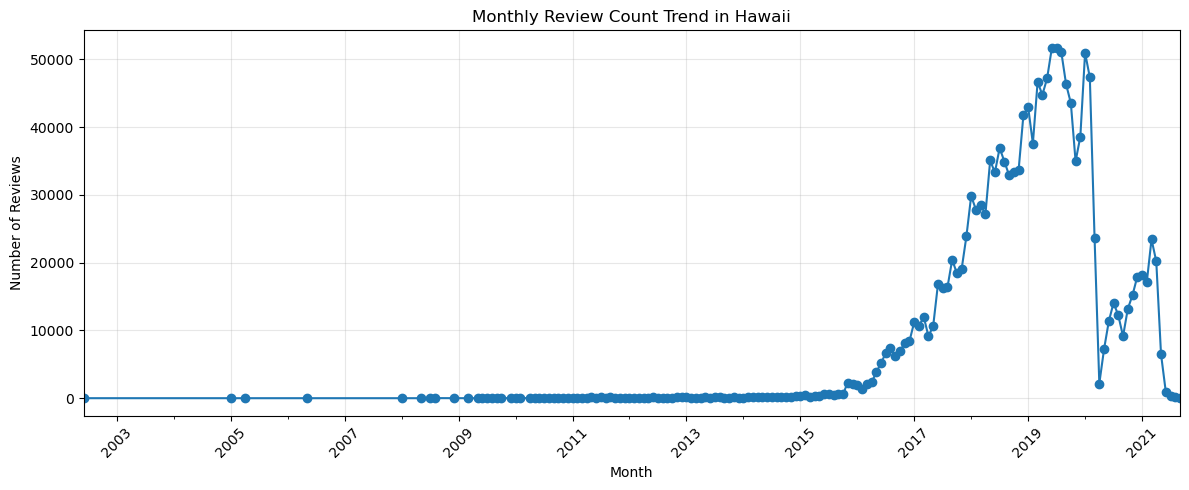

In [42]:
# ---------- Convert time (milliseconds) to datetime ----------
reviews["time_dt"] = pd.to_datetime(reviews["time"], unit="ms", errors="coerce")
reviews = reviews.dropna(subset=["time_dt"])

# ---------- Extract year-month ----------
reviews["year_month"] = reviews["time_dt"].dt.to_period("M")

# ---------- Count reviews per month ----------
monthly_counts = reviews.groupby("year_month").size()

# ---------- Plot ----------
plt.figure(figsize=(12,5))
monthly_counts.plot(kind="line", marker="o")
plt.xlabel("Month")
plt.ylabel("Number of Reviews")
plt.title("Monthly Review Count Trend in Hawaii")
plt.xticks(rotation=45)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

### 0.3.2 Global rating trend per year

/var/folders/sr/5f197r3d4fdd3dfvb_9fcw6w0000gn/T/ipykernel_76821/1408886390.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reviews_filtered["quarter"] = reviews_filtered["time_dt"].dt.to_period("Q")


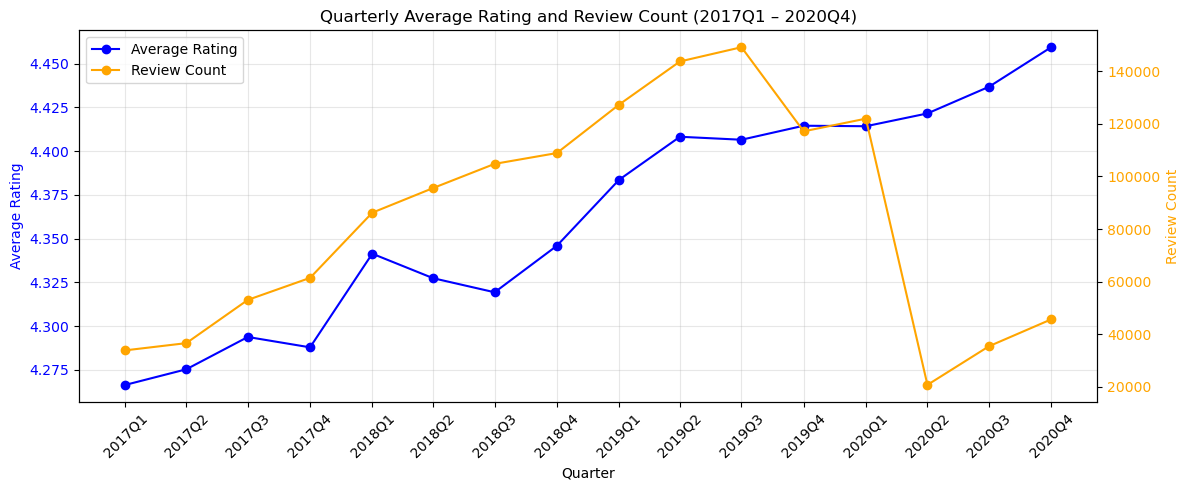

In [43]:
# ---------- Filter reviews between 2017Q1 and 2020Q4 ----------
reviews_filtered = reviews[(reviews["time_dt"] >= "2017-01-01") & (reviews["time_dt"] <= "2020-12-31")]

# ---------- Extract year-quarter ----------
reviews_filtered["quarter"] = reviews_filtered["time_dt"].dt.to_period("Q")

# ---------- Compute quarterly average rating ----------
quarterly_avg = reviews_filtered.groupby("quarter")["rating"].mean().reset_index()
quarterly_avg["quarter_dt"] = quarterly_avg["quarter"].dt.to_timestamp()

# ---------- Compute quarterly review counts ----------
quarterly_counts = reviews_filtered.groupby("quarter").size().reset_index(name="review_count")
quarterly_counts["quarter_dt"] = quarterly_counts["quarter"].dt.to_timestamp()

# ---------- Plot ----------
fig, ax1 = plt.subplots(figsize=(12,5), facecolor='white')  # White background

# Line 1: Average rating
ax1.plot(quarterly_avg["quarter_dt"], quarterly_avg["rating"], marker="o", color="blue", label="Average Rating")
ax1.set_xlabel("Quarter")
ax1.set_ylabel("Average Rating", color="blue")
ax1.tick_params(axis='y', labelcolor="blue")
ax1.grid(alpha=0.3)

# Line 2: Review count on secondary y-axis
ax2 = ax1.twinx()
ax2.plot(quarterly_counts["quarter_dt"], quarterly_counts["review_count"], marker="o", color="orange", label="Review Count")
ax2.set_ylabel("Review Count", color="orange")
ax2.tick_params(axis='y', labelcolor="orange")

# X-axis: quarterly labels
ax1.set_xticks(quarterly_avg["quarter_dt"])
ax1.set_xticklabels([str(q) for q in quarterly_avg["quarter"].astype(str)], rotation=45)

# Title
plt.title("Quarterly Average Rating and Review Count (2017Q1 – 2020Q4)")

# Legends
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc="upper left")

plt.tight_layout()
plt.show()

## 0.4 Business Average Rating Analysis

### 0.4.1 Average rating by number of reviews

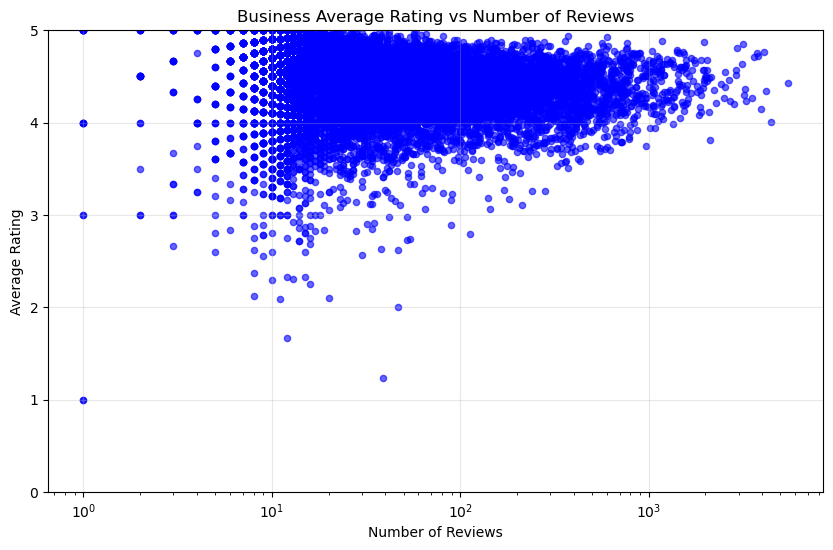

In [44]:
business_reviews = reviews_filtered.groupby("gmap_id").agg(
    num_reviews=("rating", "count"),
    avg_rating=("rating", "mean")
).reset_index()

# ---------- Plot scatter ----------
plt.figure(figsize=(10,6))
plt.scatter(
    business_reviews["num_reviews"], 
    business_reviews["avg_rating"], 
    alpha=0.6, 
    s=20,
    color='blue'
)
plt.xlabel("Number of Reviews")
plt.ylabel("Average Rating")
plt.title("Business Average Rating vs Number of Reviews")
plt.xscale('log')  # log scale for better visualization
plt.ylim(0,5)
plt.grid(True, alpha=0.3)
plt.show()

### 0.4.2 Regional average review count with K-Means clustering

In [45]:
import folium
from folium import CircleMarker
from sklearn.cluster import KMeans
# ------------ Merge metadata to add latitude / longitude ------------
business_geo = business[["gmap_id", "latitude", "longitude"]].drop_duplicates()

business_reviews = business_reviews.merge(
    business_geo,
    on="gmap_id",
    how="left"
)

# Remove rows without valid coordinates
business_reviews = business_reviews.dropna(subset=["latitude", "longitude"]).copy()


# ---------------- Run KMeans on coordinates ------------------
coords = business_reviews[["latitude", "longitude"]].to_numpy()

K = 20
kmeans = KMeans(n_clusters=K, random_state=42, n_init="auto")
business_reviews["cluster"] = kmeans.fit_predict(coords)

# ------------------ Compute average number of reviews per cluster ------------------
cluster_stats = (
    business_reviews.groupby("cluster")["num_reviews"]
    .mean()
    .rename("avg_reviews_cluster")
    .reset_index()
)

# merge cluster stats back
business_reviews = business_reviews.merge(cluster_stats, on="cluster", how="left")


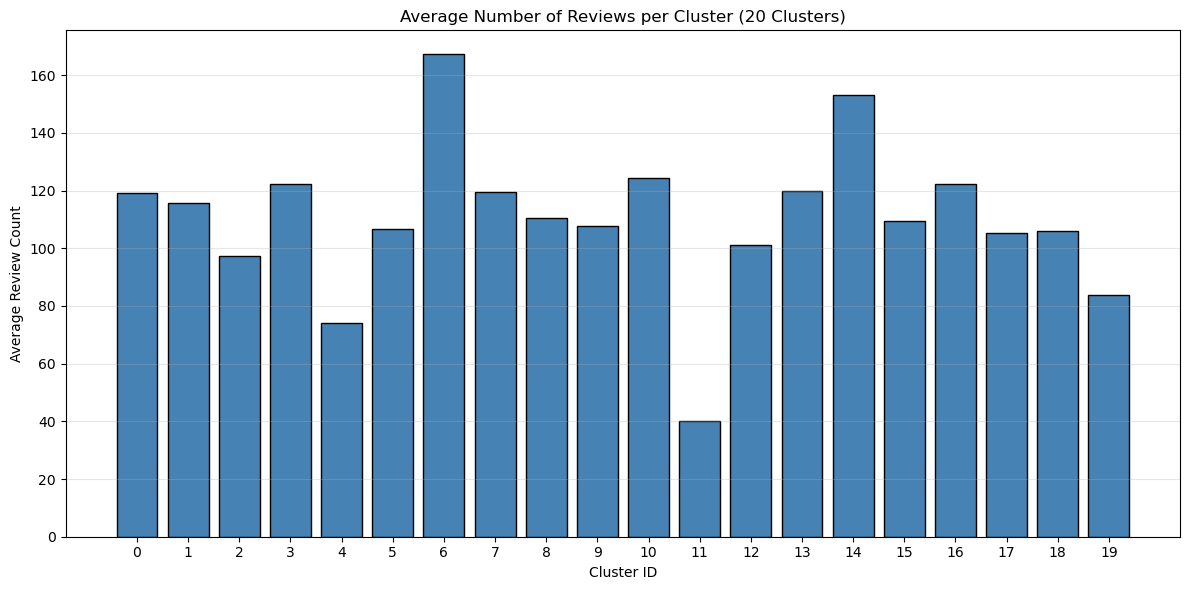

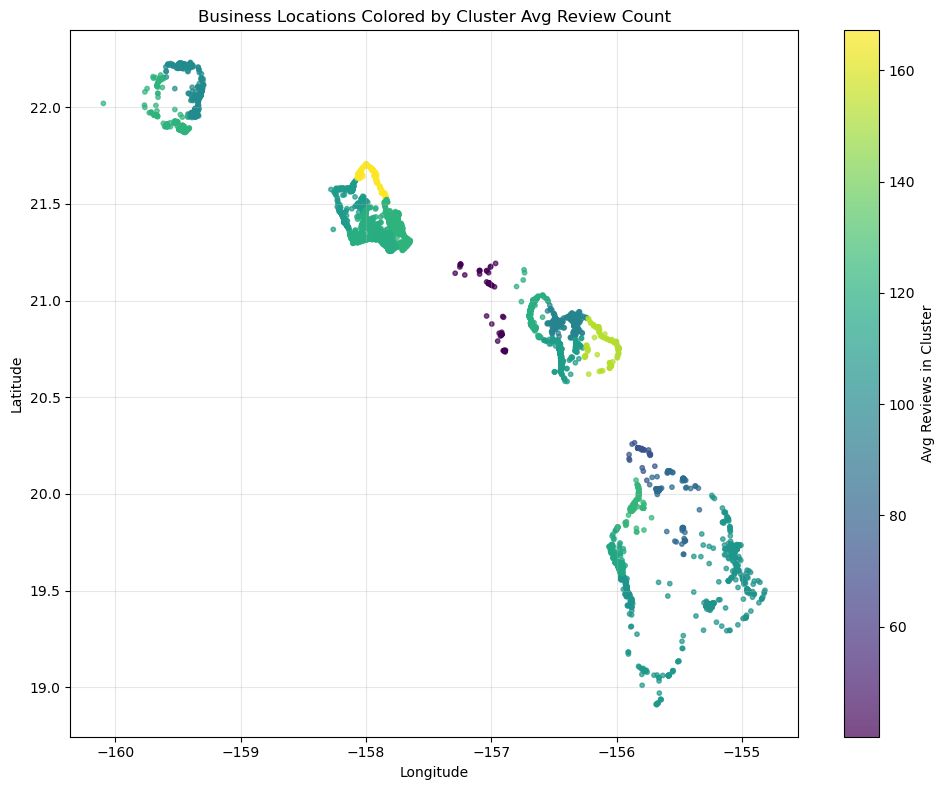

In [46]:
# ------------------- Plot histogram of avg reviews per cluster ----------------------
plt.figure(figsize=(12,6))

plt.bar(
    cluster_stats["cluster"], 
    cluster_stats["avg_reviews_cluster"],
    color='steelblue', 
    edgecolor='black'
)

plt.xlabel("Cluster ID")
plt.ylabel("Average Review Count")
plt.title("Average Number of Reviews per Cluster (20 Clusters)")
plt.xticks(cluster_stats["cluster"])  
plt.grid(axis="y", alpha=0.3)

plt.tight_layout()
plt.show()

# ------------------- Define color map based on avg number of reviews -----------------
def review_color(x):
    if x >= 150:
        return "darkred"
    elif x >= 120:
        return "red"
    elif x >= 100:
        return "orange"
    elif x >= 80:
        return "green"
    else:
        return "blue"

# -------------------------
# 6. Draw Scatters
# -------------------------
plt.figure(figsize=(10, 8))

scatter = plt.scatter(
    business_reviews["longitude"],
    business_reviews["latitude"],
    c=business_reviews["avg_reviews_cluster"], 
    cmap="viridis",                            
    s=10,                                        
    alpha=0.7
)

plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Business Locations Colored by Cluster Avg Review Count")

cbar = plt.colorbar(scatter)
cbar.set_label("Avg Reviews in Cluster")

plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show() 

### 0.4.3 Average rating by category

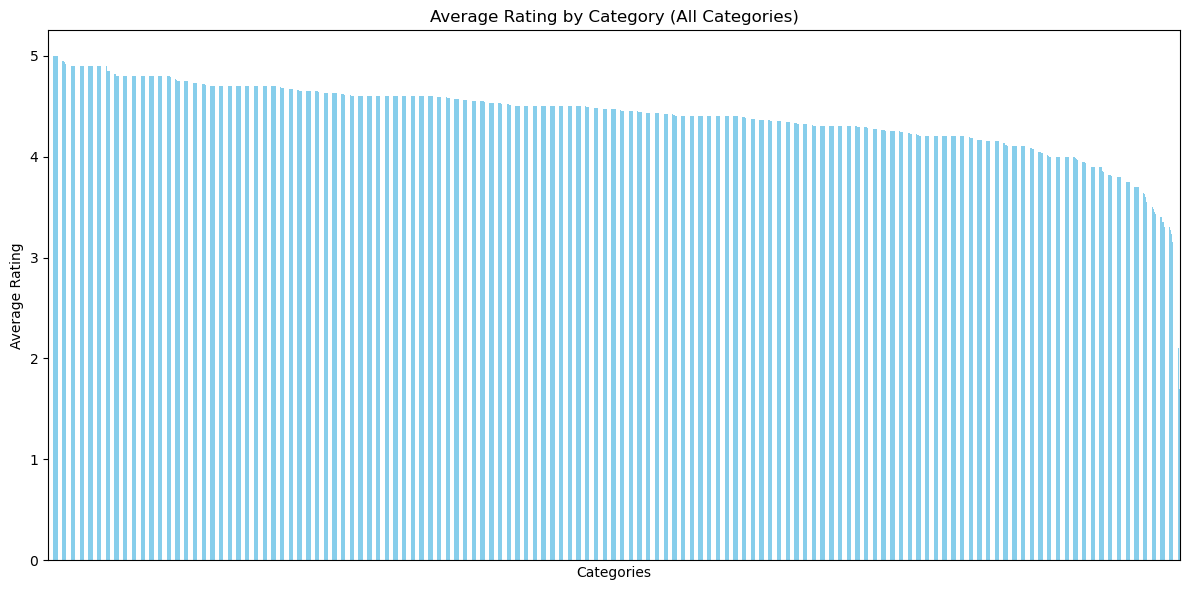

In [47]:
# Take first category if it's a list
def get_first_category(cat):
    if isinstance(cat, list):
        return cat[0] if len(cat) > 0 else None
    return cat

# Filter category and rating
business_valid = business.dropna(subset=["category", "avg_rating"]).copy()
business_valid["category_single"] = business_valid["category"].apply(get_first_category)

# Group by single category
category_avg = business_valid.groupby("category_single")["avg_rating"].mean().reset_index()
category_avg = category_avg.sort_values("avg_rating", ascending=False)

# Plot
plt.figure(figsize=(12,6))
category_avg['avg_rating'].plot(kind='bar', color='skyblue')
plt.xlabel("Categories")
plt.ylabel("Average Rating")
plt.title("Average Rating by Category (All Categories)")
plt.xticks([])  # hide x-axis labels to avoid overlap
plt.tight_layout()
plt.show()

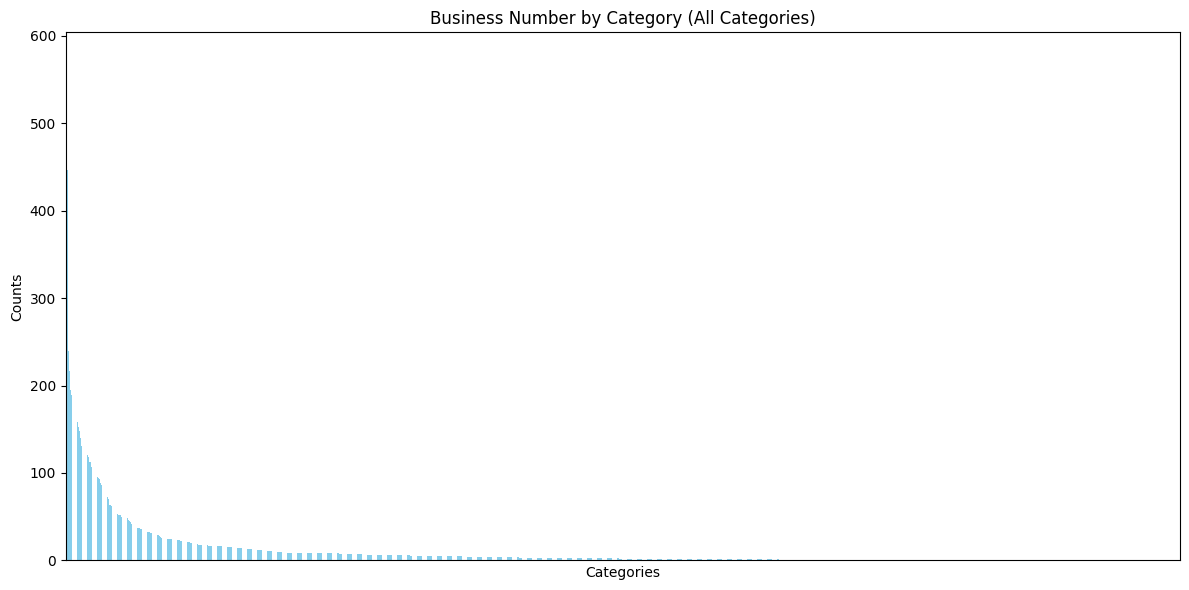

In [10]:
import pandas as pd

# --------- Helper: get first category if it's a list ----------
def get_primary_category(cat):
    if isinstance(cat, list) and len(cat) > 0:
        return cat[0]
    return "Unknown"

# --------- Create single-category column ----------
business_copy = business.copy()
business_copy["category_single"] = business_copy["category"].apply(get_primary_category)

# --------- Count number of businesses per category ----------
category_counts = (
    business_copy
    .groupby("category_single")
    .size()
    .reset_index(name="business_count")
    .sort_values("business_count", ascending=False)
)

# --------- Show result ----------
plt.figure(figsize=(12,6))
category_counts['business_count'].plot(kind='bar', color='skyblue')
plt.xlabel("Categories")
plt.ylabel("Counts")
plt.title("Business Number by Category (All Categories)")
plt.xticks([])  # hide x-axis labels to avoid overlap
plt.tight_layout()
plt.show()

     macro_category  business_count
0   Food & Beverage            3763
1          Shopping            2965
2             Other            1514
3       Attractions            1362
4        Recreation             717
5     Accommodation             519
6           Service             268
7      Construction             230
8          Religion             155
9        Healthcare             124
10         Business              44
     macro_category  avg_rating
8          Religion    4.674194
1       Attractions    4.511233
5        Healthcare    4.430645
3      Construction    4.401739
6             Other    4.356209
10         Shopping    4.342125
7        Recreation    4.291353
4   Food & Beverage    4.270050
0     Accommodation    4.230250
9           Service    4.138060
2          Business    3.956818


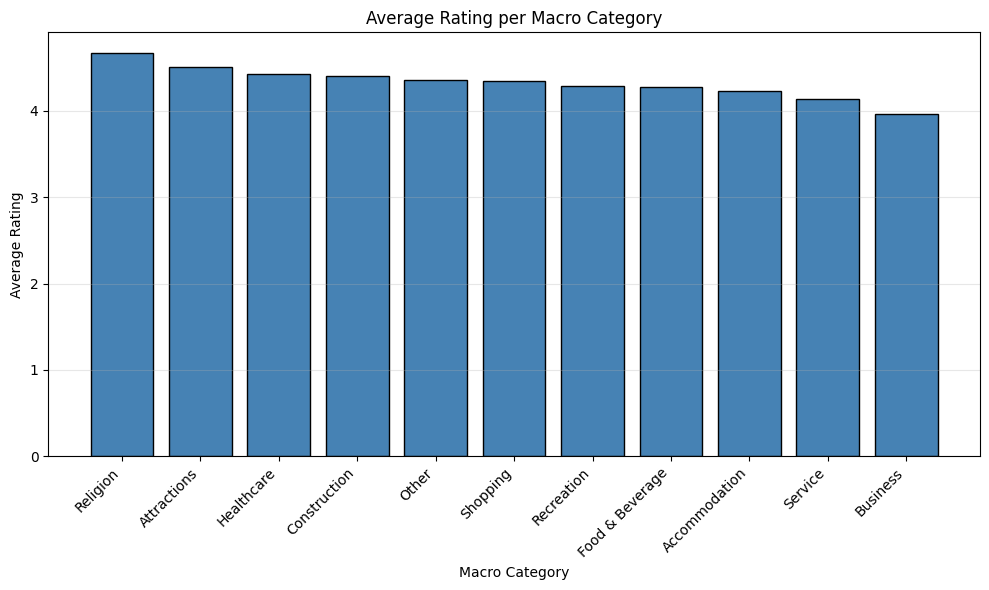

In [28]:
import pandas as pd

# Example: business dataframe
# business["primary_category"] already exists

def map_to_macro_category(cat):
    if pd.isna(cat):
        return "Other"
    
    c = cat.lower()
    
    if any(k in c for k in ["restaurant", "cafe", "food", "bar", "coffee", "steak"]):
        return "Food & Beverage"
    elif any(k in c for k in ["hotel", "motel", "resort", "inn", "lodging","vacation","rental", "housing"]):
        return "Accommodation"
    elif any(k in c for k in ["beach", "park", "scenic", "tour", "tourist", "attraction", "botanical", "wildlife", "museum", "zoo", "bay", "island", "marina", "hiking"]):
        return "Attractions"
    elif any(k in c for k in ["shop", "store", "mall", "market", "optician", "retail", "business", "agency", "dealer"]):
        return "Shopping" 
    elif any(k in c for k in ["clinic", "doctor", "dental", "dentist", "medical", "oral", "osteopath", "pharmacy", "surgeon", "pet", "care"]):
        return "Healthcare"
    elif any(k in c for k in ["church", "religious", "temple", "mosque"]):
        return "Religion"
    elif any(k in c for k in ["construction", "equipment", "supplier", "contractor", "facility", "complex"]):
        return "Construction"
    elif any(k in c for k in ["recreation", "gym", "fitness", "sports", "theater", "massage", "spa", "salon", "gym", "service", "amusement", "video", "radio", "shooting", "cultural"]):
        return "Recreation"
    elif any(k in c for k in ["conference", "company", "cooperative"]):
        return "Business"
    elif any(k in c for k in ["post", "organization", "station"]):
        return "Service"
    else:
        return "Other"

# Apply mapping
business["macro_category"] = business_copy["category_single"].apply(map_to_macro_category)

# Count business numbers per macro category
category_counts = (
    business["macro_category"]
    .value_counts()
    .reset_index()
)
category_counts.columns = ["macro_category", "business_count"]

print(category_counts)

# Compute average rating per macro category
category_avg_rating = (
    business.groupby("macro_category")["avg_rating"]
    .mean()
    .reset_index()
)

category_avg_rating = category_avg_rating.sort_values("avg_rating", ascending=False)

print(category_avg_rating)

# Optional: plot bar chart
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.bar(
    category_avg_rating["macro_category"],
    category_avg_rating["avg_rating"],
    color="steelblue",
    edgecolor="black"
)
plt.ylabel("Average Rating")
plt.xlabel("Macro Category")
plt.title("Average Rating per Macro Category")
plt.xticks(rotation=45, ha="right")
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()

## 1. Data Loading Functions

In [5]:
def load_json_gz_to_df(path):
    records = []
    with gzip.open(path, "rt", encoding="utf-8") as f:
        for line in f:
            if line.strip():
                records.append(json.loads(line))
    return pd.DataFrame(records)

print("Loading metadata...")
meta_df = load_json_gz_to_df(META_PATH)
print("Metadata rows:", len(meta_df))

print("Loading 10-core reviews...")
reviews_df = load_json_gz_to_df(REVIEW_PATH)
print("Reviews rows:", len(reviews_df))

Loading metadata...
Metadata rows: 21507
Loading 10-core reviews...
Reviews rows: 1504347


In [6]:
print(meta_df.head(2))
print(reviews_df.head(2))

                          name  \
0                    Hale Pops   
1  SMP - Single Marine Program   

                                             address  \
0   Hale Pops, 55-370 Kamehameha Hwy, Laie, HI 96762   
1  SMP - Single Marine Program, G St, Kailua, HI ...   

                                 gmap_id description   latitude   longitude  \
0   0x7c00456eecad3111:0x8217f9600c51f33        None  21.637796 -157.920714   
1  0x7c00159b5b1b1d25:0x8d2d85d4a758290e        None  21.440345 -157.754347   

              category  avg_rating  num_of_reviews price  \
0         [Restaurant]         4.4              18  None   
1  [Recreation center]         4.1              18  None   

                                               hours  \
0  [[Thursday, 11AM–8PM], [Friday, 11AM–8PM], [Sa...   
1  [[Thursday, 8AM–9PM], [Friday, 8AM–9PM], [Satu...   

                                                MISC                state  \
0  {'Service options': ['Outdoor seating', 'Takeo...  Closed ⋅ 

## 2. Time Processing: Extract Year from 'time' & Filter 2017–2021

In [7]:
reviews_df = reviews_df[reviews_df["time"].notnull()].copy()
reviews_df["datetime"] = pd.to_datetime(reviews_df["time"], unit="ms")
reviews_df["year"] = reviews_df["datetime"].dt.year
reviews_df = reviews_df[(reviews_df["year"] >= 2017) & (reviews_df["year"] <= 2021)].copy()

print("Reviews after year filter:", len(reviews_df))
print(reviews_df["year"].value_counts().sort_index())

Reviews after year filter: 1429207
year
2017    185042
2018    395462
2019    537254
2020    224535
2021     86914
Name: count, dtype: int64


## 3. Construct Per-Business Average Rating by Year (2017–2021)

In [8]:
by_biz_year = (
    reviews_df
    .groupby(["gmap_id", "year"])["rating"]
    .agg(["mean", "count"])
    .reset_index()
    .rename(columns={"mean": "avg_rating_year", "count": "num_reviews_year"})
)

# Calculate total reviews in 2017-2020 period for filtering
reviews_2017_2020 = reviews_df[(reviews_df["year"] >= 2017) & (reviews_df["year"] <= 2020)]
biz_review_counts_2017_2020 = reviews_2017_2020.groupby("gmap_id").size().reset_index(name="num_reviews_2017_2020")

year_pivot = by_biz_year.pivot_table(
    index="gmap_id",
    columns="year",
    values="avg_rating_year"
)

year_pivot.columns = [f"avg_{int(c)}" for c in year_pivot.columns]
year_pivot = year_pivot.reset_index()

# Merge review counts for 2017-2020 period
year_pivot = year_pivot.merge(biz_review_counts_2017_2020, on="gmap_id", how="left")
year_pivot["num_reviews_2017_2020"] = year_pivot["num_reviews_2017_2020"].fillna(0)

year_pivot.head()

,gmap_id,avg_2017,avg_2018,avg_2019,avg_2020,avg_2021,num_reviews_2017_2020
0,0x0:0x9edcb14b0cf1ec04,3.666667,1.800000,4.200000,5.000000,5.000000,18.0
1,0x1150a1a2df43910f:0xc3419d135191bbca,3.333333,4.400000,4.000000,NaN,NaN,13.0
2,0x115668f3c694d673:0x73bfd141c6e1669b,5.000000,4.666667,5.000000,4.857143,3.000000,16.0
3,0x11566d436f0c4cc1:0xb0d0dbfba1351beb,4.583333,4.250000,4.473684,4.882353,4.833333,60.0
4,0x11566dad4a2c7545:0xed4746f5f86444a2,5.000000,4.333333,4.857143,4.600000,3.000000,24.0


In [9]:
biz_with_2021 = year_pivot[year_pivot["avg_2021"].notnull()].copy()
print("Businesses with 2021 rating:", len(biz_with_2021))

Businesses with 2021 rating: 9089


## 4. Process Metadata and Join

In [10]:
meta_cols = [
    "gmap_id",
    "latitude",
    "longitude",
    "category",
    "num_of_reviews",
    "price",
]

meta_small = meta_df[meta_cols].copy()

def get_primary_category(cat_list):
    if isinstance(cat_list, list) and len(cat_list) > 0:
        return cat_list[0]
    return "Unknown"

meta_small["primary_category"] = meta_small["category"].apply(get_primary_category)
meta_small.drop(columns=["category"], inplace=True)
meta_small["num_of_reviews"] = meta_small["num_of_reviews"].fillna(0)

# Merge: biz_with_2021 already contains num_reviews_2017_2020 from year_pivot
data = biz_with_2021.merge(meta_small, on="gmap_id", how="left")
print("Merged rows:", len(data))
print("Columns in data:", data.columns.tolist())
data.head()

Merged rows: 9108
Columns in data: ['gmap_id', 'avg_2017', 'avg_2018', 'avg_2019', 'avg_2020', 'avg_2021', 'num_reviews_2017_2020', 'latitude', 'longitude', 'num_of_reviews', 'price', 'primary_category']


,gmap_id,avg_2017,avg_2018,avg_2019,avg_2020,avg_2021,num_reviews_2017_2020,latitude,longitude,num_of_reviews,price,primary_category
0,0x0:0x9edcb14b0cf1ec04,3.666667,1.800000,4.200000,5.000000,5.000000,18.0,21.300920,-157.858630,278,None,SCUBA instructor
1,0x115668f3c694d673:0x73bfd141c6e1669b,5.000000,4.666667,5.000000,4.857143,3.000000,16.0,20.773887,-156.450867,28,None,Calvary Chapel church
2,0x11566d436f0c4cc1:0xb0d0dbfba1351beb,4.583333,4.250000,4.473684,4.882353,4.833333,60.0,20.883286,-156.453187,143,None,Laundromat
3,0x11566dad4a2c7545:0xed4746f5f86444a2,5.000000,4.333333,4.857143,4.600000,3.000000,24.0,20.855721,-156.664017,67,None,Vacation home rental agency
4,0x13fe0333c445c2df:0xa21f660433680bf1,4.272727,4.054054,4.263158,3.809524,3.888889,137.0,21.279403,-157.825591,428,$$,Korean restaurant


## 5. Regional Features (KMeans)

In [11]:
data = data[data["latitude"].notnull() & data["longitude"].notnull()].copy()
coords = data[["latitude", "longitude"]].to_numpy()

K = 20
kmeans = KMeans(n_clusters=K, random_state=42, n_init="auto")
cluster_labels = kmeans.fit_predict(coords)
data["region_cluster"] = cluster_labels

cluster_stats = (
    data.groupby("region_cluster")["num_of_reviews"]
    .mean()
    .rename("regional_avg_reviews")
    .reset_index()
)

data = data.merge(cluster_stats, on="region_cluster", how="left")
data.head()

,gmap_id,avg_2017,avg_2018,avg_2019,avg_2020,avg_2021,num_reviews_2017_2020,latitude,longitude,num_of_reviews,price,primary_category,region_cluster,regional_avg_reviews
0,0x0:0x9edcb14b0cf1ec04,3.666667,1.800000,4.200000,5.000000,5.000000,18.0,21.300920,-157.858630,278,None,SCUBA instructor,5,309.355666
1,0x115668f3c694d673:0x73bfd141c6e1669b,5.000000,4.666667,5.000000,4.857143,3.000000,16.0,20.773887,-156.450867,28,None,Calvary Chapel church,2,340.945455
2,0x11566d436f0c4cc1:0xb0d0dbfba1351beb,4.583333,4.250000,4.473684,4.882353,4.833333,60.0,20.883286,-156.453187,143,None,Laundromat,11,267.420000
3,0x11566dad4a2c7545:0xed4746f5f86444a2,5.000000,4.333333,4.857143,4.600000,3.000000,24.0,20.855721,-156.664017,67,None,Vacation home rental agency,6,423.004684
4,0x13fe0333c445c2df:0xa21f660433680bf1,4.272727,4.054054,4.263158,3.809524,3.888889,137.0,21.279403,-157.825591,428,$$,Korean restaurant,5,309.355666


## 6. Construct Feature Matrix X and Label y

In [20]:
hist_cols = ["avg_2017", "avg_2018", "avg_2019", "avg_2020"]
row_mean = data[hist_cols].mean(axis=1)
for c in hist_cols:
    data[c] = data[c].fillna(row_mean)

global_mean_rating = reviews_df["rating"].mean()
data[hist_cols] = data[hist_cols].fillna(global_mean_rating)

# Store unfiltered data for parameter tuning
data_unfiltered = data.copy()

# Filter businesses with <20 reviews in 2017-2020 period (not just total reviews)
# Also keep the original filter for total reviews >= 20
data = data[(data['num_reviews_2017_2020'] >= 20) & (data['num_of_reviews'] >= 20)].copy()

print(f"Businesses after filtering (>=20 reviews in 2017-2020): {len(data)}")

y = data["avg_2021"].values

numeric_features = [
    # "latitude",
    # "longitude",
    # "num_of_reviews",
    # "regional_avg_reviews",
    "avg_2017",
    "avg_2018",
    "avg_2019",
    "avg_2020",
]

categorical_features = ["price", "primary_category"]
gmap_id = ["gmap_id"]

# X = data[numeric_features + categorical_features + gmap_id].copy()

X = data[numeric_features+gmap_id].copy()
print("Feature shape:", X.shape, "Label shape:", y.shape)

Businesses after filtering (>=20 reviews in 2017-2020): 6682
Feature shape: (6682, 5) Label shape: (6682,)


## 7. Train/Test Split

In [21]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

## 8. Parameter Tuning: Filter Thresholds (10, 20 reviews)


In [22]:
# Parameter tuning: test different filter thresholds
# Use data_unfiltered to test different thresholds
filter_thresholds = [10, 20]

print("=== Parameter Tuning: Filter Thresholds ===")
for threshold in filter_thresholds:
    # Filter data with current threshold from unfiltered data
    data_filtered = data_unfiltered[(data_unfiltered['num_reviews_2017_2020'] >= threshold) & 
                                    (data_unfiltered['num_of_reviews'] >= threshold)].copy()
    print(f"\nThreshold: {threshold} reviews")
    print(f"  Number of businesses: {len(data_filtered)}")
    print(f"  Average reviews per business (2017-2020): {data_filtered['num_reviews_2017_2020'].mean():.2f}")
    print(f"  Median reviews per business (2017-2020): {data_filtered['num_reviews_2017_2020'].median():.2f}")

print("\nUsing threshold = 20 for main model training (as specified)")


=== Parameter Tuning: Filter Thresholds ===

Threshold: 10 reviews
  Number of businesses: 6682
  Average reviews per business (2017-2020): 180.09
  Median reviews per business (2017-2020): 78.00

Threshold: 20 reviews
  Number of businesses: 6682
  Average reviews per business (2017-2020): 180.09
  Median reviews per business (2017-2020): 78.00

Using threshold = 20 for main model training (as specified)


Calculate sample weights (heavier weight on more popular businesses)

In [23]:


# Calculate sample weights based on number of reviews (2017-2020 period)
# More popular businesses (with more reviews) get higher weights
def calculate_sample_weights(num_reviews, method='log'):
    """
    Calculate sample weights based on number of reviews.
    method: 'log' (logarithmic scaling) or 'linear' (linear scaling)
    """
    if method == 'log':
        # Logarithmic scaling: weight = log(1 + num_reviews)
        weights = np.log1p(num_reviews)
    elif method == 'linear':
        # Linear scaling: weight = num_reviews
        weights = num_reviews
    else:
        weights = np.ones_like(num_reviews)
    
    # Normalize to have mean = 1 (optional, but helps with model stability)
    weights = weights / weights.mean()
    return weights

# Get review counts for training data
train_review_counts = data.loc[X_train.index, "num_reviews_2017_2020"].values
sample_weights_train = calculate_sample_weights(train_review_counts, method='log')

print(f"Sample weights stats:")
print(f"  Min: {sample_weights_train.min():.4f}")
print(f"  Max: {sample_weights_train.max():.4f}")
print(f"  Mean: {sample_weights_train.mean():.4f}")
print(f"  Median: {np.median(sample_weights_train):.4f}")

Sample weights stats:
  Min: 0.6687
  Max: 1.8909
  Mean: 1.0000
  Median: 0.9624


## 9. Time Decay Weighted Average

In [24]:
# Time decay weighted average


def time_decay_weighted_average(review_df, lambda_=1e-7):
    """
    calculate a time-decay weighted average rating for a given gmap_id
    review_df must contain ['time', 'rating']
    """

    if review_df.empty:
        return np.nan

    max_time = review_df["time"].max()
    time_diff = max_time - review_df["time"]

    weights = np.exp(-lambda_ * time_diff)

    return np.sum(weights * review_df["rating"]) / np.sum(weights)


def compute_time_decay_for_all(df_reviews, lambda_=1e-7):
    results = []
    for gmap_id, group in df_reviews.groupby("gmap_id"):
        td_rating = time_decay_weighted_average(group, lambda_)
        results.append({"gmap_id": gmap_id, "time_decay_rating": td_rating})
    return pd.DataFrame(results)


df_td = compute_time_decay_for_all(reviews_df, lambda_=1e-7)
merged_test_df = X_test.merge(df_td, on="gmap_id", how="left")

In [26]:

def evaluate_time_decay_baseline(y_test, pred):
    """
    assess the ability of the time decay baseline
    y_test: numpy array
    pred: numpy array or pandas Series
    """
    pred = np.array(pred)  # make sure is numpy array

    # basic metrics
    mse = mean_squared_error(y_test, pred)
    mae = mean_absolute_error(y_test, pred)
    r2 = r2_score(y_test, pred)

    # prediction rate
    diff = np.abs(y_test - pred)

    acc_03 = np.mean(diff <= 0.3)
    acc_05 = np.mean(diff <= 0.5)
    acc_10 = np.mean(diff <= 1.0)

    print("=== Time Decay Weighted Average Baseline ===")
    print("Test MSE :", mse)
    print("Test MAE :", mae)
    print("Test R²  :", r2)
    print(f"Prediction Rate @0.3 star: {acc_03:.4f}")
    print(f"Prediction Rate @0.5 star: {acc_05:.4f}")
    print(f"Prediction Rate @1.0 star: {acc_10:.4f}")
    print()

    return pred

pred = merged_test_df["time_decay_rating"]
y_pred_td = evaluate_time_decay_baseline(y_test, pred)

=== Time Decay Weighted Average Baseline ===
Test MSE : 0.5757313398545056
Test MAE : 0.492777062436559
Test R²  : -0.6704137706548228
Prediction Rate @0.3 star: 0.4384
Prediction Rate @0.5 star: 0.6564
Prediction Rate @1.0 star: 0.8903



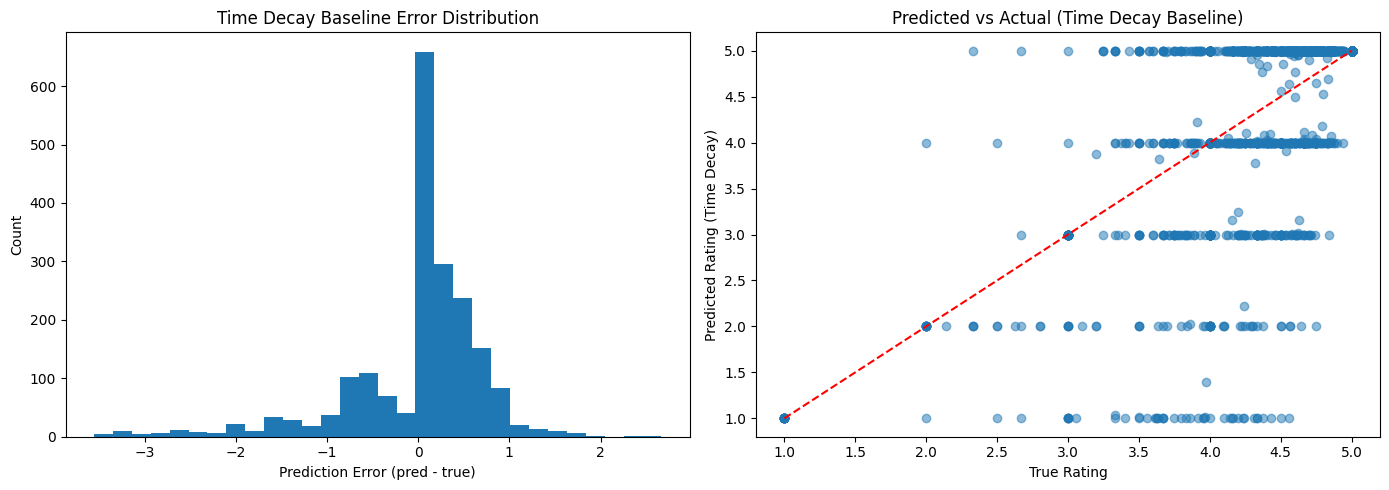

In [27]:
errors = pred - y_test

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 1. Error Distribution Histogram
# plt.figure(figsize=(7,5))
axes[0].hist(errors, bins=30)
axes[0].set_xlabel("Prediction Error (pred - true)")
axes[0].set_ylabel("Count")
axes[0].set_title("Time Decay Baseline Error Distribution")

# 2. Pred vs Actual Scatter Plot
axes[1].scatter(y_test, pred, alpha=0.5)
plt.plot([1,5], [1,5], 'r--', label='Perfect prediction')
axes[1].set_xlabel("True Rating")
axes[1].set_ylabel("Predicted Rating (Time Decay)")
axes[1].set_title("Predicted vs Actual (Time Decay Baseline)")

plt.tight_layout()
plt.show()


## 10. Preprocessing + Three Models (LR / RF / XGBoost)

In [30]:
preprocessor = ColumnTransformer(
    transformers=[
        #("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features),
        ("num", "passthrough", numeric_features),
    ]
)

linreg_model = Pipeline(
    steps=[
        ("preprocess", preprocessor),
        ("model", LinearRegression()),
    ]
)

rf_model = Pipeline(
    steps=[
        ("preprocess", preprocessor),
        ("model", RandomForestRegressor(
            n_estimators=200,
            random_state=42,
            n_jobs=-1
        )),
    ]
)

# ★★★ better model：XGBoost ★★★
xgb_model = Pipeline(
    steps=[
        ("preprocess", preprocessor),
        ("model", XGBRegressor(
            n_estimators=600,
            learning_rate=0.05,
            max_depth=6,
            subsample=0.9,
            colsample_bytree=0.9,
            reg_lambda=1.0,
            objective="reg:squarederror",
            random_state=42,
            n_jobs=-1
        )),
    ]
)

## 11. Train and Evaluate Three Models

In [31]:
def evaluate_model(name, model, X_train, X_test, y_train, y_test, sample_weight=None):
    """
    Evaluate model with optional sample weights.
    sample_weight: array-like of shape (n_samples,), optional
    """
    if sample_weight is not None:
        # For Pipeline models, pass sample_weight through fit_params
        try:
            model.fit(X_train, y_train, model__sample_weight=sample_weight)
        except:
            # Fallback: try direct fit if model doesn't support it
            model.fit(X_train, y_train)
    else:
        model.fit(X_train, y_train)
    
    y_pred_test = model.predict(X_test)

    # basic metrics
    mse = mean_squared_error(y_test, y_pred_test)
    mae = mean_absolute_error(y_test, y_pred_test)
    r2 = r2_score(y_test, y_pred_test)

    # prediction rate（in differnt error threshold）
    diff = np.abs(y_test - y_pred_test)
    acc_03 = np.mean(diff <= 0.3)
    acc_05 = np.mean(diff <= 0.5)
    acc_10 = np.mean(diff <= 1.0)

    print(f"=== {name} ===")
    if sample_weight is not None:
        print("(with sample weights - heavier weight on popular businesses)")
    print("Test MSE :", mse)
    print("Test MAE :", mae)
    print("Test R²  :", r2)
    print(f"Prediction Rate @0.3 star: {acc_03:.4f}")
    print(f"Prediction Rate @0.5 star: {acc_05:.4f}")
    print(f"Prediction Rate @1.0 star: {acc_10:.4f}")
    print()

    return y_pred_test


# Train models without sample weights (baseline)
print("=== Models WITHOUT Sample Weights ===")
y_pred_lr = evaluate_model("Linear Regression", linreg_model, X_train, X_test, y_train, y_test)
y_pred_rf = evaluate_model("Random Forest", rf_model, X_train, X_test, y_train, y_test)
y_pred_xgb = evaluate_model("XGBoost", xgb_model, X_train, X_test, y_train, y_test)


# Train models with sample weights (heavier weight on popular businesses)
print("\n=== Models WITH Sample Weights (heavier weight on popular businesses) ===")

# Linear Regression with sample weights
linreg_model_weighted = Pipeline(
    steps=[
        ("preprocess", preprocessor),
        ("model", LinearRegression()),
    ]
)

# Random Forest with sample weights
rf_model_weighted = Pipeline(
    steps=[
        ("preprocess", preprocessor),
        ("model", RandomForestRegressor(
            n_estimators=200,
            random_state=42,
            n_jobs=-1
        )),
    ]
)

# XGBoost with sample weights (supports sample_weight parameter)
xgb_model_weighted = Pipeline(
    steps=[
        ("preprocess", preprocessor),
        ("model", XGBRegressor(
            n_estimators=600,
            learning_rate=0.05,
            max_depth=6,
            subsample=0.9,
            colsample_bytree=0.9,
            reg_lambda=1.0,
            objective="reg:squarederror",
            random_state=42,
            n_jobs=-1
        )),
    ]
)

# Fit with sample weights
y_pred_lr_weighted = evaluate_model(
    "Linear Regression",
    linreg_model_weighted,
    X_train,
    X_test,
    y_train,
    y_test,
    sample_weight=sample_weights_train,
)

y_pred_rf_weighted = evaluate_model(
    "Random Forest",
    rf_model_weighted,
    X_train,
    X_test,
    y_train,
    y_test,
    sample_weight=sample_weights_train,
)

y_pred_xgb_weighted = evaluate_model(
    "XGBoost",
    xgb_model_weighted,
    X_train,
    X_test,
    y_train,
    y_test,
    sample_weight=sample_weights_train,
)

# Use weighted XGBoost as the main model for further analysis
y_pred_xgb = y_pred_xgb_weighted
xgb_model = xgb_model_weighted


=== Models WITHOUT Sample Weights ===
=== Linear Regression ===
Test MSE : 0.306786408555644
Test MAE : 0.36621111587168925
Test R²  : 0.10989691540747248
Prediction Rate @0.3 star: 0.5646
Prediction Rate @0.5 star: 0.7805
Prediction Rate @1.0 star: 0.9496

=== Random Forest ===
Test MSE : 0.33904994387337645
Test MAE : 0.39743656291557894
Test R²  : 0.01628823032465576
Prediction Rate @0.3 star: 0.5227
Prediction Rate @0.5 star: 0.7382
Prediction Rate @1.0 star: 0.9337

=== XGBoost ===
Test MSE : 0.3654354436428055
Test MAE : 0.4111263367887521
Test R²  : -0.06026605656131112
Prediction Rate @0.3 star: 0.5147
Prediction Rate @0.5 star: 0.7272
Prediction Rate @1.0 star: 0.9267


=== Models WITH Sample Weights (heavier weight on popular businesses) ===
=== Linear Regression ===
(with sample weights - heavier weight on popular businesses)
Test MSE : 0.3075559991261604
Test MAE : 0.36638620535078215
Test R²  : 0.10766404288904818
Prediction Rate @0.3 star: 0.5666
Prediction Rate @0.5 star

## 12. Visualization (Using XGBoost)

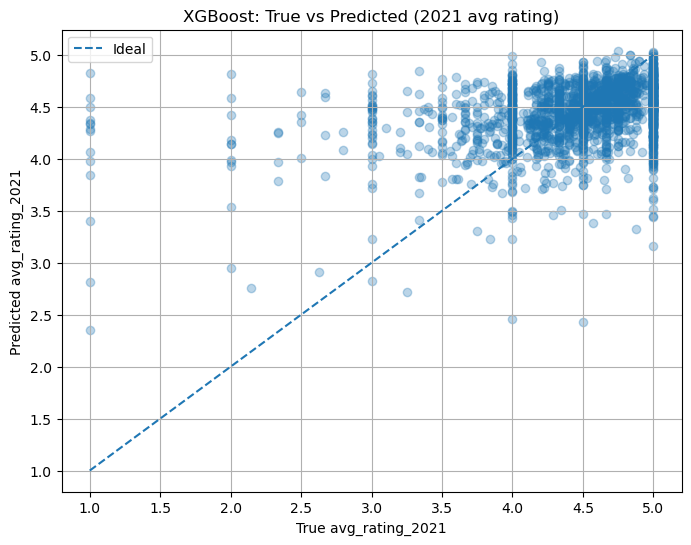

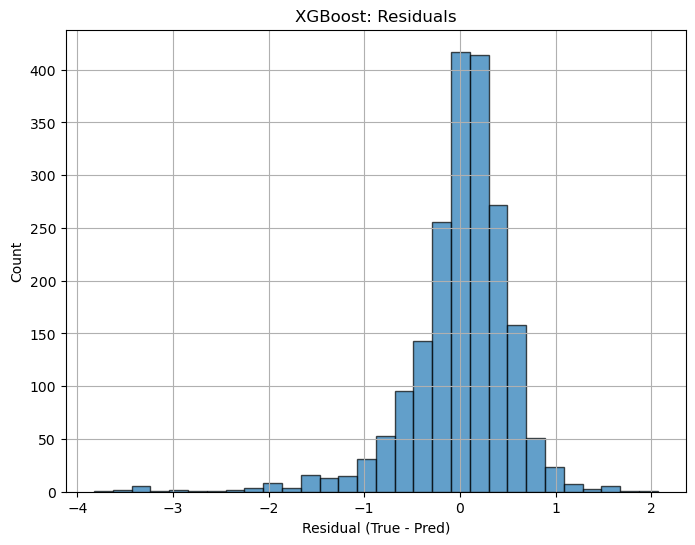

In [64]:
def plot_pred_vs_true(y_true, y_pred, title=""):
    plt.figure()
    plt.scatter(y_true, y_pred, alpha=0.3)
    plt.plot([1, 5], [1, 5], "--", label="Ideal")
    plt.xlabel("True avg_rating_2021")
    plt.ylabel("Predicted avg_rating_2021")
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_residuals(y_true, y_pred, title=""):
    residuals = y_true - y_pred
    plt.figure()
    plt.hist(residuals, bins=30, edgecolor="k", alpha=0.7)
    plt.xlabel("Residual (True - Pred)")
    plt.ylabel("Count")
    plt.title(title)
    plt.grid(True)
    plt.show()

plot_pred_vs_true(y_test, y_pred_xgb, title="XGBoost: True vs Predicted (2021 avg rating)")
plot_residuals(y_test, y_pred_xgb, title="XGBoost: Residuals")

## 13. Analysis (Also Using XGBoost)

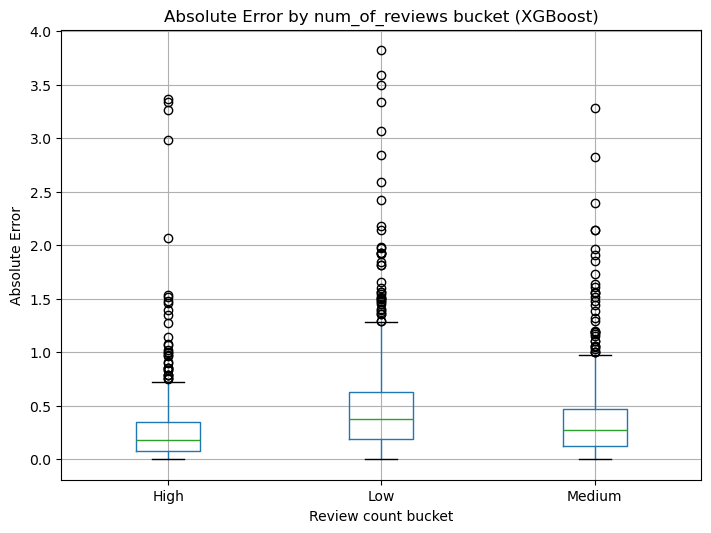

             y_true_2021  y_pred_2021
price_label                          
Cheap           4.460472     4.453527
Moderate        4.386282     4.402420
Expensive       4.492841     4.451778
Luxury          4.726853     4.598081


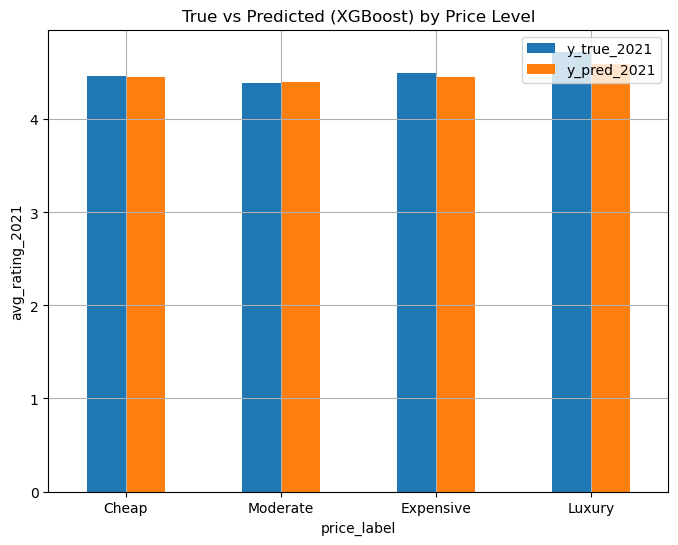

In [65]:
analysis_df = data.loc[X_test.index].copy()
analysis_df["y_true_2021"] = y_test
analysis_df["y_pred_2021"] = y_pred_xgb
analysis_df["abs_error"] = np.abs(analysis_df["y_true_2021"] - analysis_df["y_pred_2021"])

analysis_df[["gmap_id", "y_true_2021", "y_pred_2021", "abs_error"]].head()

# review bucket
quantiles = analysis_df["num_of_reviews"].quantile([0.33, 0.66]).values
q1, q2 = quantiles[0], quantiles[1]

def bucket_reviews(n):
    if n <= q1:
        return "Low"
    elif n <= q2:
        return "Medium"
    else:
        return "High"

analysis_df["review_bucket"] = analysis_df["num_of_reviews"].apply(bucket_reviews)

analysis_df.boxplot(column="abs_error", by="review_bucket")
plt.title("Absolute Error by num_of_reviews bucket (XGBoost)")
plt.suptitle("")
plt.xlabel("Review count bucket")
plt.ylabel("Absolute Error")
plt.grid(True)
plt.show()

# price analysis
def classify_price(p):
    if p is None:
        return "Cheap"
    p_str = str(p).strip()
    length = len(p_str)
    if length <= 1:
        return "Cheap"
    elif length == 2:
        return "Moderate"
    elif length == 3:
        return "Expensive"
    else:
        return "Luxury"

analysis_df["price_label"] = analysis_df["price"].apply(classify_price)

price_stats_labeled = (
    analysis_df.groupby("price_label")[["y_true_2021", "y_pred_2021"]]
    .mean()
    .reindex(["Cheap", "Moderate", "Expensive", "Luxury"])
)

print(price_stats_labeled)

price_stats_labeled.plot(kind="bar", rot=0)
plt.ylabel("avg_rating_2021")
plt.title("True vs Predicted (XGBoost) by Price Level")
plt.grid(True)
plt.show()

## 14. Evaluation: Popular Businesses (What We Most Care About)


=== Evaluation: Popular vs Non-Popular Businesses ===
Total test businesses: 2005
Popular businesses (top 50% by review count): 1009
Non-popular businesses: 996

Popular businesses threshold: >= 75 reviews in 2017-2020

=== MSE Comparison ===
MSE (All businesses): 0.3079
MSE (Popular businesses): 0.1846
MSE (Non-popular businesses): 0.4329

=== Precision (Accuracy within 0.5 stars) ===
Precision (All businesses): 0.7556
Precision (Popular businesses): 0.8444
Precision (Non-popular businesses): 0.6657


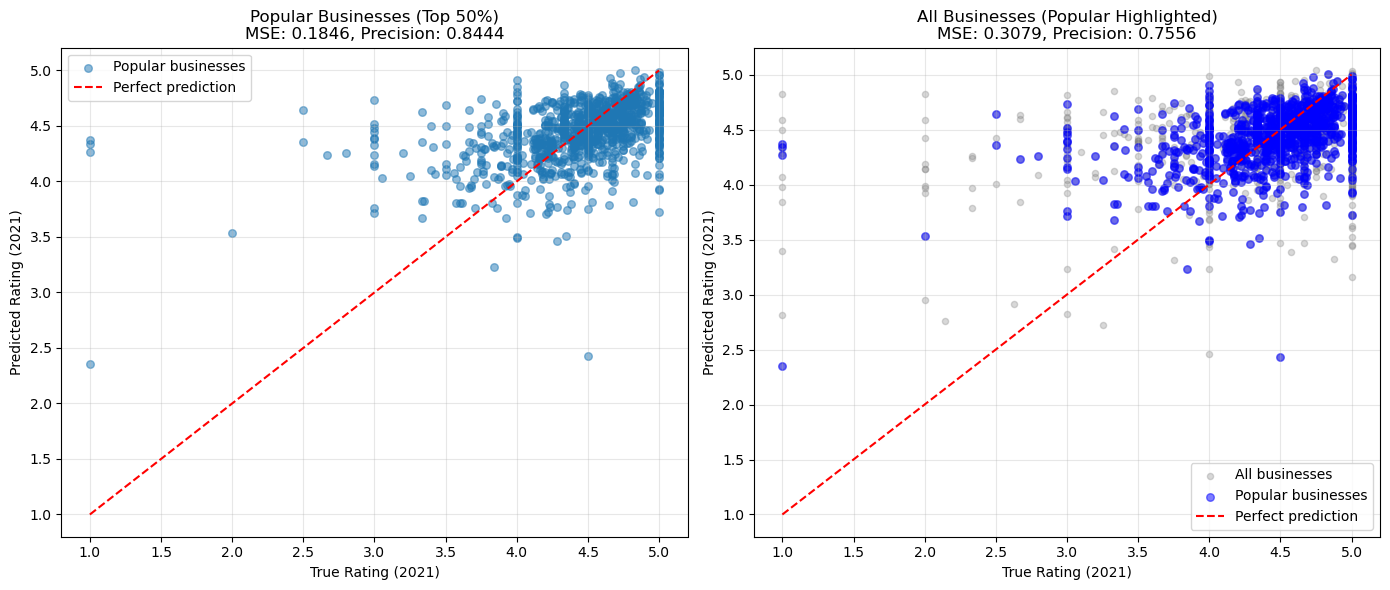

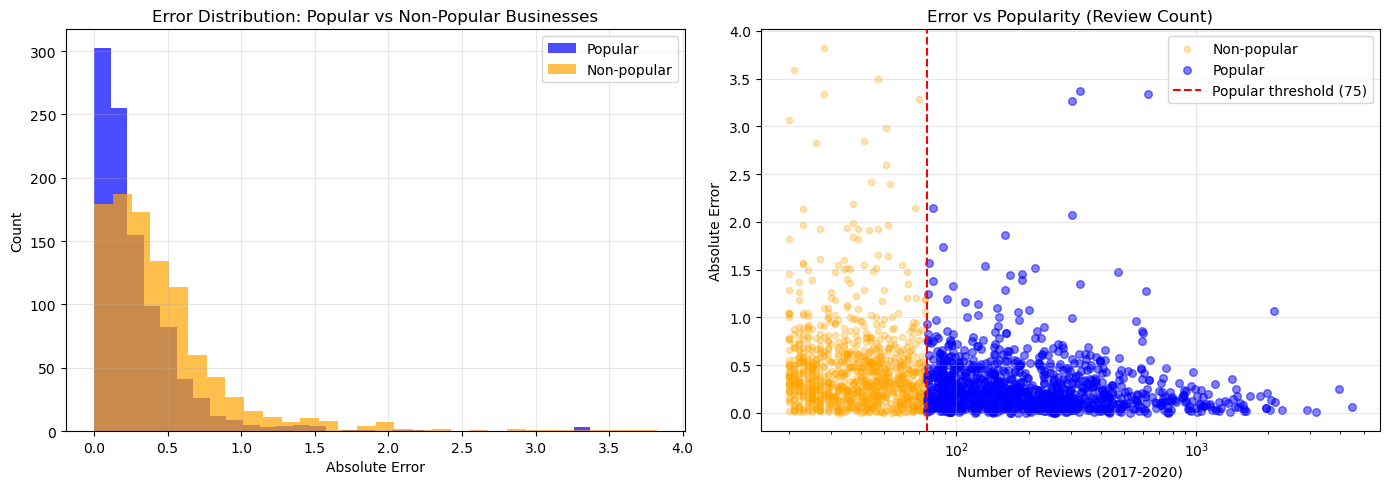


=== Summary ===
Popular businesses (with more reviews) are what we most care about.
The model achieves MSE=0.1846 and Precision=0.8444 on popular businesses.
Sample weighting helps the model focus more on these important businesses during training.


In [66]:
# Evaluation: Focus on popular businesses (what we most care about)
# Sort businesses by popularity (number of reviews in 2017-2020)

# Get test data with review counts
test_analysis_df = data.loc[X_test.index].copy()
test_analysis_df["y_true_2021"] = y_test
test_analysis_df["y_pred_2021"] = y_pred_xgb
test_analysis_df["abs_error"] = np.abs(test_analysis_df["y_true_2021"] - test_analysis_df["y_pred_2021"])

# Sort by popularity (number of reviews in 2017-2020)
test_analysis_df = test_analysis_df.sort_values("num_reviews_2017_2020", ascending=False)

# Define popular businesses (top 50% by review count)
popular_threshold = test_analysis_df["num_reviews_2017_2020"].quantile(0.5)
popular_businesses = test_analysis_df[test_analysis_df["num_reviews_2017_2020"] >= popular_threshold].copy()
non_popular_businesses = test_analysis_df[test_analysis_df["num_reviews_2017_2020"] < popular_threshold].copy()

print("=== Evaluation: Popular vs Non-Popular Businesses ===")
print(f"Total test businesses: {len(test_analysis_df)}")
print(f"Popular businesses (top 50% by review count): {len(popular_businesses)}")
print(f"Non-popular businesses: {len(non_popular_businesses)}")
print(f"\nPopular businesses threshold: >= {popular_threshold:.0f} reviews in 2017-2020")

# Calculate MSE for popular businesses
mse_popular = mean_squared_error(popular_businesses["y_true_2021"], popular_businesses["y_pred_2021"])
mse_non_popular = mean_squared_error(non_popular_businesses["y_true_2021"], non_popular_businesses["y_pred_2021"])
mse_all = mean_squared_error(test_analysis_df["y_true_2021"], test_analysis_df["y_pred_2021"])

print(f"\n=== MSE Comparison ===")
print(f"MSE (All businesses): {mse_all:.4f}")
print(f"MSE (Popular businesses): {mse_popular:.4f}")
print(f"MSE (Non-popular businesses): {mse_non_popular:.4f}")

# Calculate precision-like metrics (for regression, we use accuracy within thresholds)
# Precision in regression context: percentage of predictions within acceptable error range
error_threshold = 0.5  # 0.5 star tolerance
precision_popular = np.mean(popular_businesses["abs_error"] <= error_threshold)
precision_non_popular = np.mean(non_popular_businesses["abs_error"] <= error_threshold)
precision_all = np.mean(test_analysis_df["abs_error"] <= error_threshold)

print(f"\n=== Precision (Accuracy within {error_threshold} stars) ===")
print(f"Precision (All businesses): {precision_all:.4f}")
print(f"Precision (Popular businesses): {precision_popular:.4f}")
print(f"Precision (Non-popular businesses): {precision_non_popular:.4f}")

# Plot True vs Predicted for popular businesses
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Left plot: Popular businesses
axes[0].scatter(popular_businesses["y_true_2021"], popular_businesses["y_pred_2021"], 
                alpha=0.5, s=30, label='Popular businesses')
axes[0].plot([1, 5], [1, 5], 'r--', label='Perfect prediction')
axes[0].set_xlabel("True Rating (2021)")
axes[0].set_ylabel("Predicted Rating (2021)")
axes[0].set_title(f"Popular Businesses (Top 50%)\nMSE: {mse_popular:.4f}, Precision: {precision_popular:.4f}")
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Right plot: All businesses for comparison
axes[1].scatter(test_analysis_df["y_true_2021"], test_analysis_df["y_pred_2021"], 
                alpha=0.3, s=20, c='gray', label='All businesses')
axes[1].scatter(popular_businesses["y_true_2021"], popular_businesses["y_pred_2021"], 
                alpha=0.5, s=30, c='blue', label='Popular businesses')
axes[1].plot([1, 5], [1, 5], 'r--', label='Perfect prediction')
axes[1].set_xlabel("True Rating (2021)")
axes[1].set_ylabel("Predicted Rating (2021)")
axes[1].set_title(f"All Businesses (Popular Highlighted)\nMSE: {mse_all:.4f}, Precision: {precision_all:.4f}")
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Additional analysis: Error distribution by popularity
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Error distribution
axes[0].hist(popular_businesses["abs_error"], bins=30, alpha=0.7, label='Popular', color='blue')
axes[0].hist(non_popular_businesses["abs_error"], bins=30, alpha=0.7, label='Non-popular', color='orange')
axes[0].set_xlabel("Absolute Error")
axes[0].set_ylabel("Count")
axes[0].set_title("Error Distribution: Popular vs Non-Popular Businesses")
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Error vs Review Count
axes[1].scatter(non_popular_businesses["num_reviews_2017_2020"], non_popular_businesses["abs_error"], 
                alpha=0.3, s=20, c='orange', label='Non-popular')
axes[1].scatter(popular_businesses["num_reviews_2017_2020"], popular_businesses["abs_error"], 
                alpha=0.5, s=30, c='blue', label='Popular')
axes[1].axvline(x=popular_threshold, color='red', linestyle='--', label=f'Popular threshold ({popular_threshold:.0f})')
axes[1].set_xlabel("Number of Reviews (2017-2020)")
axes[1].set_ylabel("Absolute Error")
axes[1].set_title("Error vs Popularity (Review Count)")
axes[1].set_xscale('log')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n=== Summary ===")
print("Popular businesses (with more reviews) are what we most care about.")
print(f"The model achieves MSE={mse_popular:.4f} and Precision={precision_popular:.4f} on popular businesses.")
print("Sample weighting helps the model focus more on these important businesses during training.")


## 15. Model Comparison: Different Filter Thresholds (10 vs 20 reviews)


In [67]:
# Train models on data_filtered with different thresholds and compare results
# Store results for comparison
results_comparison = {}

# Original model (threshold=20) - already trained
results_comparison[20] = {
    'data': data,
    'X_train': X_train,
    'X_test': X_test,
    'y_train': y_train,
    'y_test': y_test,
    'y_pred': y_pred_xgb,
    'model': xgb_model
}

print("=== Training Models on Different Filter Thresholds ===\n")

# Train models for each threshold
for threshold in [10, 20]:
    if threshold == 20:
        # Use existing model
        print(f"Threshold {threshold}: Using existing model (already trained)")
        continue
    
    print(f"\n--- Training model with threshold = {threshold} ---")
    
    # Filter data
    data_filtered = data_unfiltered[(data_unfiltered['num_reviews_2017_2020'] >= threshold) & 
                                    (data_unfiltered['num_of_reviews'] >= threshold)].copy()
    
    # Prepare features and labels
    y_filtered = data_filtered["avg_2021"].values
    X_filtered = data_filtered[numeric_features + categorical_features + gmap_id].copy()
    
    # Train/test split
    X_train_f, X_test_f, y_train_f, y_test_f = train_test_split(
        X_filtered, y_filtered, test_size=0.3, random_state=42
    )
    
    # Calculate sample weights
    train_review_counts_f = data_filtered.loc[X_train_f.index, "num_reviews_2017_2020"].values
    sample_weights_train_f = calculate_sample_weights(train_review_counts_f, method='log')
    
    # Train XGBoost model with sample weights
    xgb_model_f = Pipeline(
        steps=[
            ("preprocess", preprocessor),
            ("model", XGBRegressor(
                n_estimators=600,
                learning_rate=0.05,
                max_depth=6,
                subsample=0.9,
                colsample_bytree=0.9,
                reg_lambda=1.0,
                objective="reg:squarederror",
                random_state=42,
                n_jobs=-1
            )),
        ]
    )
    
    xgb_model_f.fit(X_train_f, y_train_f, model__sample_weight=sample_weights_train_f)
    y_pred_f = xgb_model_f.predict(X_test_f)
    
    # Store results
    results_comparison[threshold] = {
        'data': data_filtered,
        'X_train': X_train_f,
        'X_test': X_test_f,
        'y_train': y_train_f,
        'y_test': y_test_f,
        'y_pred': y_pred_f,
        'model': xgb_model_f
    }
    
    # Evaluate
    mse_f = mean_squared_error(y_test_f, y_pred_f)
    mae_f = mean_absolute_error(y_test_f, y_pred_f)
    r2_f = r2_score(y_test_f, y_pred_f)
    diff_f = np.abs(y_test_f - y_pred_f)
    precision_f = np.mean(diff_f <= 0.5)
    
    print(f"  Test set size: {len(y_test_f)}")
    print(f"  MSE: {mse_f:.4f}")
    print(f"  MAE: {mae_f:.4f}")
    print(f"  R²: {r2_f:.4f}")
    print(f"  Precision (@0.5 stars): {precision_f:.4f}")

print("\n=== Comparison Summary ===")
for threshold in sorted(results_comparison.keys()):
    res = results_comparison[threshold]
    mse = mean_squared_error(res['y_test'], res['y_pred'])
    mae = mean_absolute_error(res['y_test'], res['y_pred'])
    r2 = r2_score(res['y_test'], res['y_pred'])
    diff = np.abs(res['y_test'] - res['y_pred'])
    precision = np.mean(diff <= 0.5)
    
    print(f"\nThreshold {threshold}:")
    print(f"  Test set size: {len(res['y_test'])}")
    print(f"  MSE: {mse:.4f}")
    print(f"  MAE: {mae:.4f}")
    print(f"  R²: {r2:.4f}")
    print(f"  Precision (@0.5 stars): {precision:.4f}")


=== Training Models on Different Filter Thresholds ===


--- Training model with threshold = 10 ---
  Test set size: 2526
  MSE: 0.4024
  MAE: 0.4165
  R²: 0.0579
  Precision (@0.5 stars): 0.7352
Threshold 20: Using existing model (already trained)

=== Comparison Summary ===

Threshold 10:
  Test set size: 2526
  MSE: 0.4024
  MAE: 0.4165
  R²: 0.0579
  Precision (@0.5 stars): 0.7352

Threshold 20:
  Test set size: 2005
  MSE: 0.3079
  MAE: 0.3736
  R²: 0.1065
  Precision (@0.5 stars): 0.7556


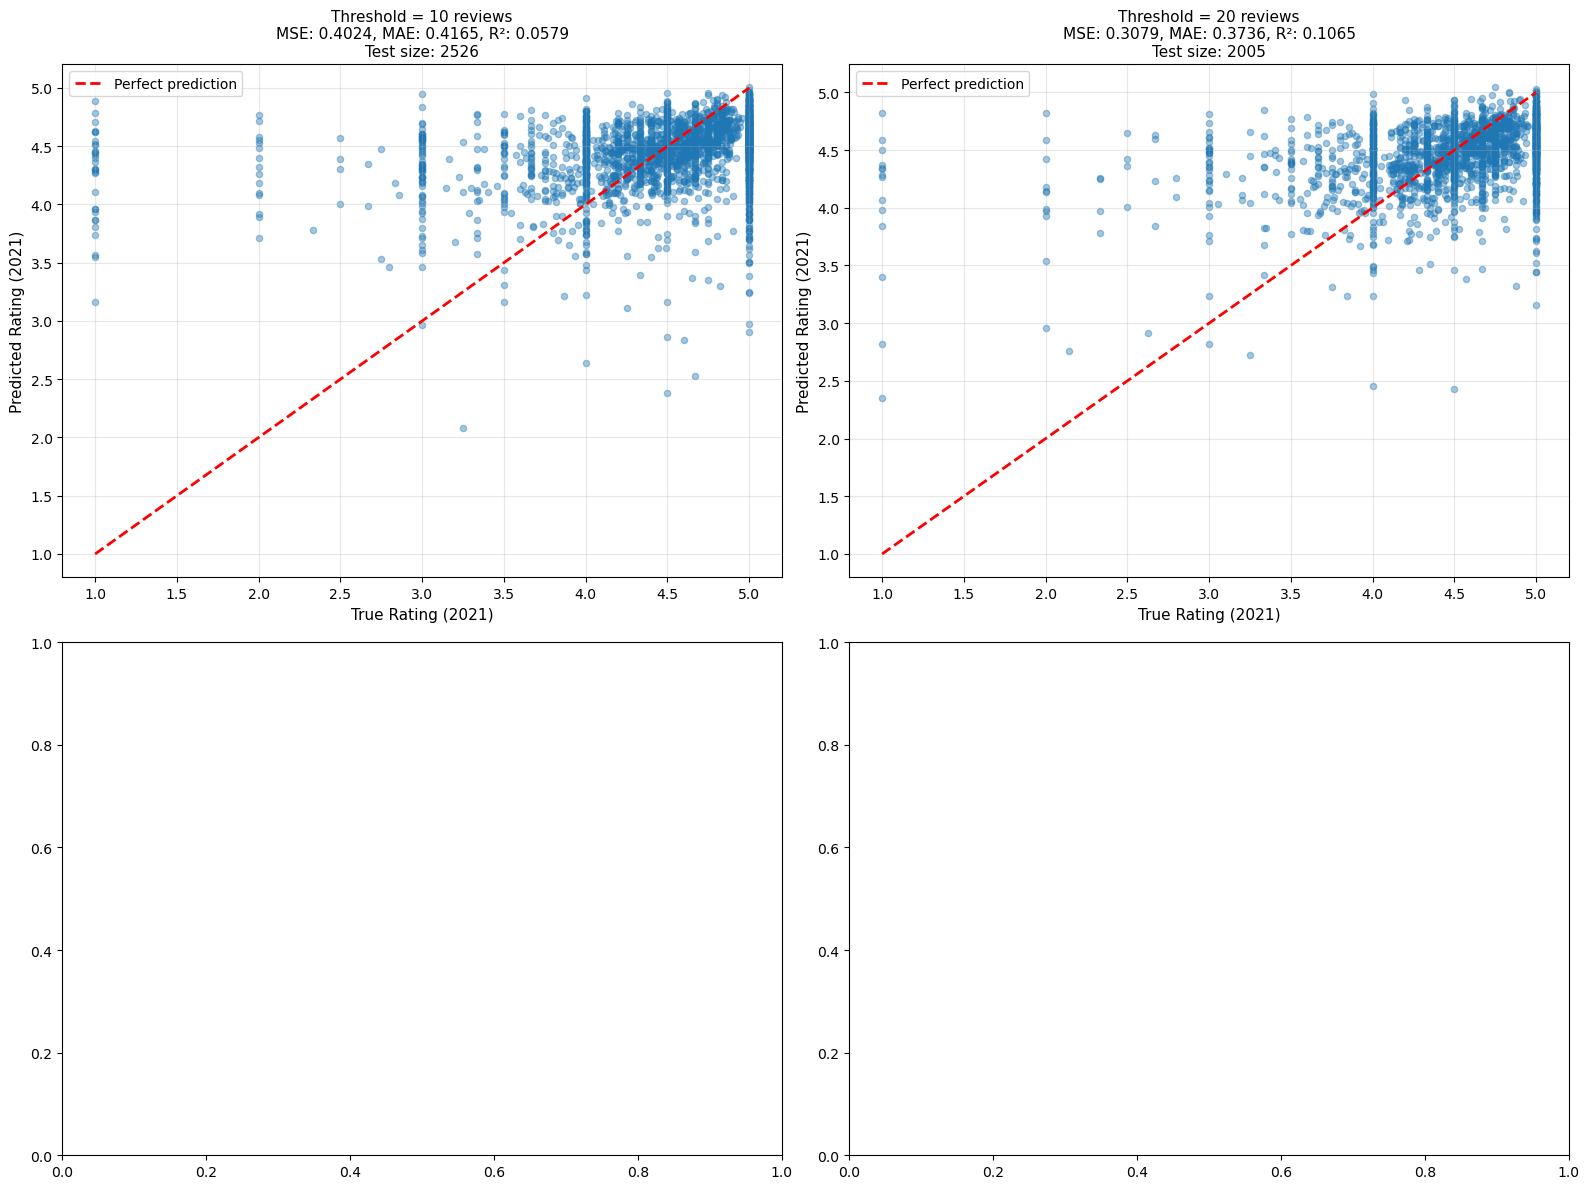

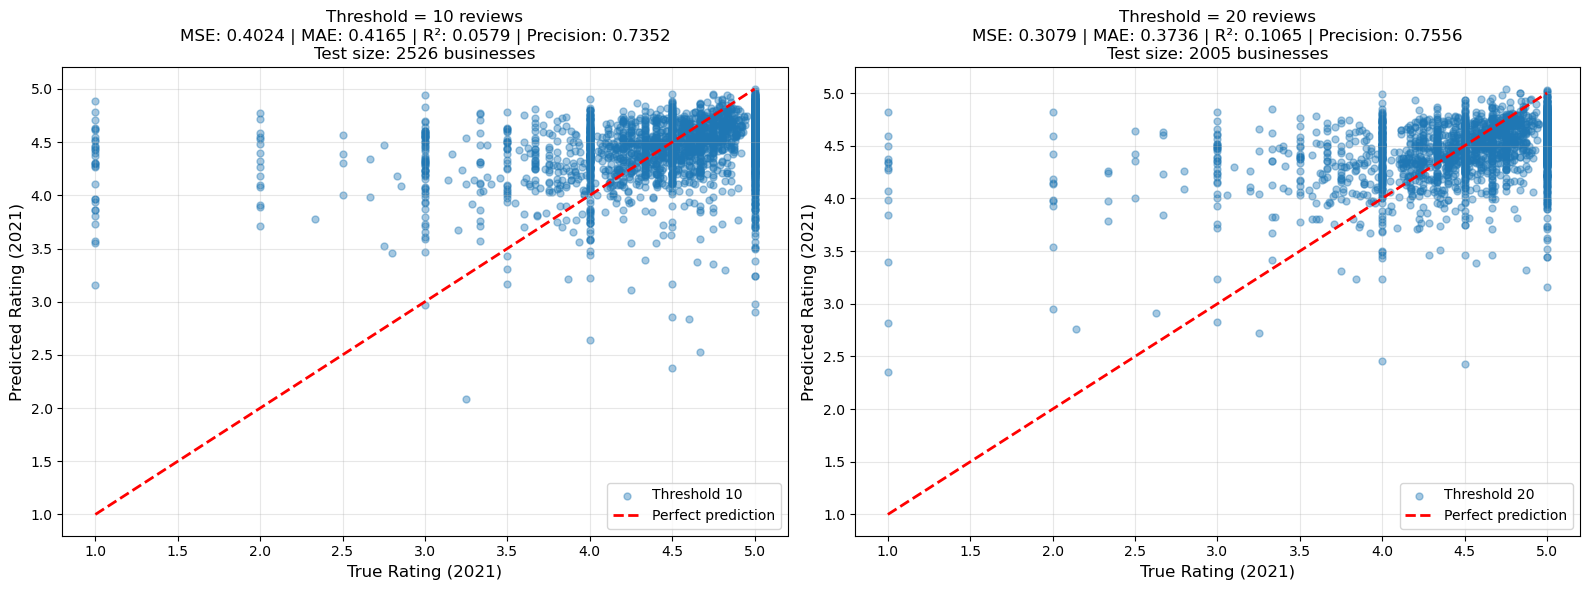

In [68]:
# Visual comparison: True vs Predicted for different thresholds
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

for idx, threshold in enumerate(sorted(results_comparison.keys())):
    res = results_comparison[threshold]
    row = idx // 2
    col = idx % 2
    
    ax = axes[row, col]
    ax.scatter(res['y_test'], res['y_pred'], alpha=0.4, s=20)
    ax.plot([1, 5], [1, 5], 'r--', label='Perfect prediction', linewidth=2)
    
    mse = mean_squared_error(res['y_test'], res['y_pred'])
    mae = mean_absolute_error(res['y_test'], res['y_pred'])
    r2 = r2_score(res['y_test'], res['y_pred'])
    
    ax.set_xlabel("True Rating (2021)", fontsize=11)
    ax.set_ylabel("Predicted Rating (2021)", fontsize=11)
    ax.set_title(f"Threshold = {threshold} reviews\n"
                 f"MSE: {mse:.4f}, MAE: {mae:.4f}, R²: {r2:.4f}\n"
                 f"Test size: {len(res['y_test'])}", fontsize=11)
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Side-by-side comparison plot
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

for idx, threshold in enumerate(sorted(results_comparison.keys())):
    res = results_comparison[threshold]
    ax = axes[idx]
    
    ax.scatter(res['y_test'], res['y_pred'], alpha=0.4, s=25, label=f'Threshold {threshold}')
    ax.plot([1, 5], [1, 5], 'r--', label='Perfect prediction', linewidth=2)
    
    mse = mean_squared_error(res['y_test'], res['y_pred'])
    mae = mean_absolute_error(res['y_test'], res['y_pred'])
    r2 = r2_score(res['y_test'], res['y_pred'])
    diff = np.abs(res['y_test'] - res['y_pred'])
    precision = np.mean(diff <= 0.5)
    
    ax.set_xlabel("True Rating (2021)", fontsize=12)
    ax.set_ylabel("Predicted Rating (2021)", fontsize=12)
    ax.set_title(f"Threshold = {threshold} reviews\n"
                 f"MSE: {mse:.4f} | MAE: {mae:.4f} | R²: {r2:.4f} | Precision: {precision:.4f}\n"
                 f"Test size: {len(res['y_test'])} businesses", fontsize=12)
    ax.legend(fontsize=10)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


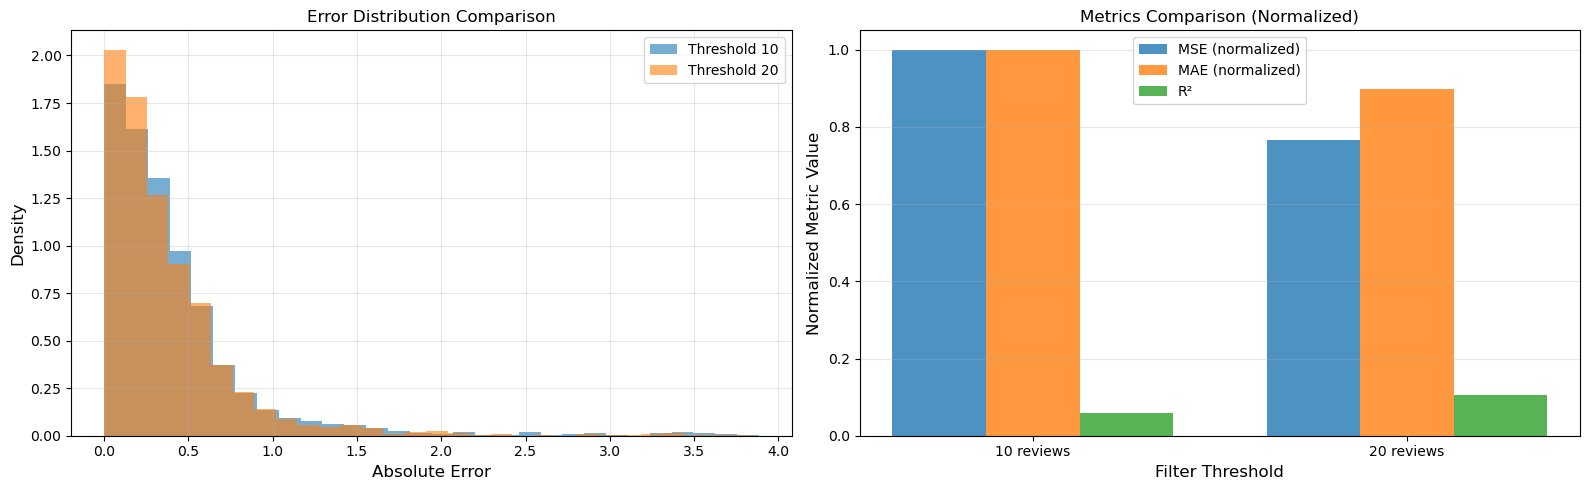


=== Detailed Metrics Comparison ===
 Threshold  Test Size      MSE      MAE       R²  Precision (@0.5)
        10       2526 0.402409 0.416458 0.057894          0.735154
        20       2005 0.307942 0.373605 0.106544          0.755611


In [69]:
# Error distribution comparison
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Left: Error histograms
for threshold in sorted(results_comparison.keys()):
    res = results_comparison[threshold]
    errors = np.abs(res['y_test'] - res['y_pred'])
    axes[0].hist(errors, bins=30, alpha=0.6, label=f'Threshold {threshold}', density=True)

axes[0].set_xlabel("Absolute Error", fontsize=12)
axes[0].set_ylabel("Density", fontsize=12)
axes[0].set_title("Error Distribution Comparison", fontsize=12)
axes[0].legend(fontsize=10)
axes[0].grid(True, alpha=0.3)

# Right: Metrics comparison bar chart
thresholds = sorted(results_comparison.keys())
mse_values = [mean_squared_error(results_comparison[t]['y_test'], results_comparison[t]['y_pred']) 
              for t in thresholds]
mae_values = [mean_absolute_error(results_comparison[t]['y_test'], results_comparison[t]['y_pred']) 
              for t in thresholds]
r2_values = [r2_score(results_comparison[t]['y_test'], results_comparison[t]['y_pred']) 
             for t in thresholds]

x = np.arange(len(thresholds))
width = 0.25

# Normalize metrics for comparison (MSE and MAE divided by max, R² as is)
mse_norm = [m / max(mse_values) for m in mse_values]
mae_norm = [m / max(mae_values) for m in mae_values]

axes[1].bar(x - width, mse_norm, width, label='MSE (normalized)', alpha=0.8)
axes[1].bar(x, mae_norm, width, label='MAE (normalized)', alpha=0.8)
axes[1].bar(x + width, r2_values, width, label='R²', alpha=0.8)

axes[1].set_xlabel("Filter Threshold", fontsize=12)
axes[1].set_ylabel("Normalized Metric Value", fontsize=12)
axes[1].set_title("Metrics Comparison (Normalized)", fontsize=12)
axes[1].set_xticks(x)
axes[1].set_xticklabels([f'{t} reviews' for t in thresholds])
axes[1].legend(fontsize=10)
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

# Detailed metrics table
print("\n=== Detailed Metrics Comparison ===")
comparison_df = pd.DataFrame({
    'Threshold': thresholds,
    'Test Size': [len(results_comparison[t]['y_test']) for t in thresholds],
    'MSE': mse_values,
    'MAE': mae_values,
    'R²': r2_values,
    'Precision (@0.5)': [np.mean(np.abs(results_comparison[t]['y_test'] - results_comparison[t]['y_pred']) <= 0.5) 
                          for t in thresholds]
})
print(comparison_df.to_string(index=False))
